### Pre-Processing

BEFORE YOU RUN THESE CELLS: 

1. Manually trim the video (using VLC, Windows Photos, etc.) such that the start of the video matches the time in `Trial_Start_hhmmss` for the first trial in the **behavior file**, and same for the end of the video (should match the last trial time) (can be viewed in Matlab).
2. Save the Matlab behavior file as a CSV file, using `writematrix(M,'M.csv')` in the Matlab command window.
-> writetable(matlabfilename, 'filename.csv')

In [77]:
import sys
import numpy as np
# from matplotlib import pyplot as plt # <- weird errors :(
import cv2
import pandas as pd
import utils
import math

In [629]:
def averted_classifier(x_features, nm):
    reasonable_height_max = 0.3*y_max #near the top of the box, anything higher and the recipient cannot be seen; top of screen
    tuft_distance = 0.12*x_max #tuft distance corresponding to monkey fully looking to the side
    y_labels = np.zeros((nm, 1))
    for i in range(nm):
        if x_features[i, 0] > 0.75 and x_features[i, 2] > 0.75 and x_features[i, 3] > 0.75:
            # the righttufts or nose may or may not be visibile, this is ok.
            if x_features[i, 5] > reasonable_height_max and x_features[i, 5] < x_features[i, 9]: # face is at a reasonable height
                if x_features[i, 6] > -1 and x_features[i, 6] < 5: # face is not angled too up nor down corresponding with height
                    if x_features[i, 7] == -100:
                        y_labels[i] = 1
                    else:
                        if x_features[i, 7] > 0 and x_features[i, 7] < tuft_distance:
                            y_labels[i] = 1
    return y_labels

In [630]:
def juicer_frequency(start_frame, end_frame, j_frames):
    j_count = 0
    start_frame = int(start_frame)
    end_frame = int(end_frame)
    for i in range(start_frame, end_frame):
        if i in j_frames:
            j_count += 1
    return j_count / (end_frame - start_frame)

In [774]:
def averted_frequency(x_features, y_juice, start_frame, end_frame, y_stereo, averted_frame):
    a_count = 0
    avert_count = 0
    clean_frames = set()
    j = -1
    for i in range(start_frame, end_frame):
        if y_juice[i] == 0 and (x_features[i, 0] > 0.75 or x_features[i, 1] > 0.75 or x_features[i, 2] > 0.75 or x_features[i, 3] > 0.75):
            j += 1
            clean_frames.add(j)
    j = -1
    for i in clean_frames:
        if i in averted_frame:
            j += 1
            avert_count += 1
            if y_stereo[j] == 1:
                a_count += 1
    if avert_count == 0:
        return np.nan
    return a_count / (avert_count)

In [632]:
def clean_window(x_predict, like, all, start, stop):
    coords = {}
    hoods = {}
    count = 0
    for i in range(start, stop):
        coords[count] = like[i]
        hoods[count] = all[i]
        count += 1
    num = len(coords)
    y_clean_juice = juicer_classifier(like, all, num)
    count = 0
    for i in range(num):
        if y_clean_juice[i] == 0 and (x_predict[i, 0] > 0.75 or x_predict[i, 1] > 0.75 or x_predict[i, 2] > 0.75 or x_predict[i, 3] > 0.75):
            count += 1
    x_features = np.zeros((count,12))
    count = -1
    for i in range(num):
        if y_clean_juice[i] == 0 and (x_predict[i, 0] > 0.75 or x_predict[i, 1] > 0.75 or x_predict[i, 2] > 0.75 or x_predict[i, 3] > 0.75):
            count += 1
            x_features[count] = x_predict[i]
    return x_features

In [109]:
def time_from_start(start, vid_start):
    if len(start) != 8 or len(vid_start) != 8:
        return -100
    start_hh = int(start[0:2])
    vid_hh = int(vid_start[0:2])
    start_mm = int(start[2:4])
    vid_mm = int(vid_start[2:4])
    start_ss = int(start[4:6])
    vid_ss = int(vid_start[4:6])
    start_ms = int(start[6:])
    vid_ms = int(vid_start[6:])
    hh = (vid_hh - start_hh) * 60000 * 60
    mm = (vid_mm - start_mm) * 60000
    ss = (vid_ss - start_ss) * 1000
    ms = (vid_ms - start_ms) * 10
    return hh + mm + ss + ms

In [1109]:
date_time = "230719_1513" # format as time of start of first trial e.g. 20230428_1148
session = 6
x_max = 342
y_max = 630
num_videos = 2
start_time = "15131467"
v2_start = "15254200"
v3_start = ""
v4_start = ""
video_path_1 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + ".mp4" # insert path here
uncropped_video_path_1 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/uncropped/" + date_time + "/" + date_time + ".mp4" # insert path here
h5_path_1 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "DLC_resnet50_Side-Juicer-3Jul11shuffle1_1400000_filtered.h5"
if num_videos > 1:
    video_path_1 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "_1" ".mp4" # insert path here
    video_path_2 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "_2" ".mp4" # insert path here
    video_path_3 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "_3" ".mp4" # insert path here
    video_path_4 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "_4" ".mp4" # insert path here

    uncropped_video_path_1 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/uncropped/" + date_time + "/" + date_time + "_1" ".mp4" # insert path here
    uncropped_video_path_2 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/uncropped/" + date_time + "/" + date_time + "_2" ".mp4" # insert path here
    uncropped_video_path_3 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/uncropped/" + date_time + "/" + date_time + "_3" ".mp4" # insert path here
    uncropped_video_path_4 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/uncropped/" + date_time + "/" + date_time + "_4" ".mp4" # insert path here

    labeled_video_path_1 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "_1" + "DLC_resnet50_Side-Juicer-3Jul11shuffle1_1400000_filtered_labeled" + ".mp4" # insert path here
    labeled_video_path_2 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "_2" + "DLC_resnet50_Side-Juicer-3Jul11shuffle1_1400000_filtered_labeled" +".mp4" # insert path here
    labeled_video_path_3 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "_3" + "DLC_resnet50_Side-Juicer-3Jul11shuffle1_1400000_filtered_labeled" +".mp4" # insert path here
    labeled_video_path_4 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "_4" + "DLC_resnet50_Side-Juicer-3Jul11shuffle1_1400000_filtered_labeled" +".mp4" # insert path here

behav_path = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/behavior/" + date_time + ".csv" # with timestamps of actions
results_path = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Results/Paper_Results_2.csv" # final CSV with all gazetracking data and video info
if num_videos > 1:
    h5_path_1 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "_1" + "DLC_resnet50_Side-Juicer-3Jul11shuffle1_1400000_filtered.h5"
    h5_path_2 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "_2" + "DLC_resnet50_Side-Juicer-3Jul11shuffle1_1400000_filtered.h5"
    h5_path_3 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "_3" + "DLC_resnet50_Side-Juicer-3Jul11shuffle1_1400000_filtered.h5"
    h5_path_4 = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/originals/for_analysis/" + date_time + "/" + date_time + "_4" + "DLC_resnet50_Side-Juicer-3Jul11shuffle1_1400000_filtered.h5"

In [678]:
date_time = "231019_1322" # format as time of start of first trial e.g. 20230428_1148
session = 1
x_max = 638
y_max = 1050
num_videos = 2
start_time = "13224497"
v2_start = "13351000"
v3_start = ""
v4_start = ""
video_path_1 = "F:/Mirror Control Take 2/for_analysis/" + date_time + ".mp4" # insert path here
h5_path_1 ="F:/Mirror Control Take 2/for_analysis/" + date_time + "DLC_resnet50_Side-Juicer-3Jul11shuffle2_1400000_filtered.h5"
if num_videos > 1:
    video_path_1 = "F:/Mirror Control Take 2/for_analysis/" + date_time + "_1" ".mp4" # insert path here
    video_path_2 = "F:/Mirror Control Take 2/for_analysis/" + date_time + "_2" ".mp4" # insert path here
    video_path_3 = "F:/Mirror Control Take 2/for_analysis/" + date_time + "_3" ".mp4" # insert path here
    video_path_4 = "F:/Mirror Control Take 2/for_analysis/" + date_time + "_4" ".mp4" # insert path here

    labeled_video_path_1 = "F:/Mirror Control Take 2/for_analysis/" + date_time + "_1" + "DLC_resnet50_Side-Juicer-3Jul11shuffle2_1400000_filtered_labeled" + ".mp4" # insert path here
    labeled_video_path_2 = "F:/Mirror Control Take 2/for_analysis/" + date_time + "_2" + "DLC_resnet50_Side-Juicer-3Jul11shuffle2_1400000_filtered_labeled" +".mp4" # insert path here
    labeled_video_path_3 = "F:/Mirror Control Take 2/for_analysis/" + date_time + "_3" + "DLC_resnet50_Side-Juicer-3Jul11shuffle2_1400000_filtered_labeled" +".mp4" # insert path here
    labeled_video_path_4 = "F:/Mirror Control Take 2/for_analysis/" + date_time + "_4" + "DLC_resnet50_Side-Juicer-3Jul11shuffle2_1400000_filtered_labeled" +".mp4" # insert path here

behav_path = "F:/Mirror Control Take 2/behavior/" + date_time + ".csv" # with timestamps of actions
results_path = "c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Results/Mirror_Control.csv" # final CSV with all gazetracking data and video info
if num_videos > 1:
    h5_path_1 = "F:/Mirror Control Take 2/for_analysis/" + date_time + "_1" + "DLC_resnet50_Side-Juicer-3Jul11shuffle2_1400000_filtered.h5"
    h5_path_2 = "F:/Mirror Control Take 2/for_analysis/" + date_time + "_2" + "DLC_resnet50_Side-Juicer-3Jul11shuffle2_1400000_filtered.h5"
    h5_path_3 = "F:/Mirror Control Take 2/for_analysis/" + date_time + "_3" + "DLC_resnet50_Side-Juicer-3Jul11shuffle2_1400000_filtered.h5"
    h5_path_4 ="F:/Mirror Control Take 2/for_analysis/" + date_time + "_4" + "DLC_resnet50_Side-Juicer-3Jul11shuffle2_1400000_filtered.h5"

In [1110]:
import moviepy.editor as mpy
from moviepy.video.fx.all import crop
from matplotlib import pyplot as plt

clip_1 = mpy.VideoFileClip(video_path_1)
if num_videos > 1:
    clip_2 = mpy.VideoFileClip(video_path_2)
if num_videos > 2:
    clip_3 = mpy.VideoFileClip(video_path_3)
if num_videos > 3:
    clip_4 = mpy.VideoFileClip(video_path_4)

In [1111]:
# get timestamps of frames (timestamps are from the video itself)
all_timestamps = []
all_timestamps_1 = []
all_timestamps_2 = []
all_timestamps_3 = []
all_timestamps_4 = []
gap_timestamps = []
for i, (tstamp, frame) in enumerate(clip_1.iter_frames(with_times=True)):
    all_timestamps_1.append(tstamp)
all_timestamps.append(all_timestamps_1)
if num_videos > 1:
    gap = all_timestamps_1[len(all_timestamps_1)-1]
    gap_timestamps.append(gap)
    for i, (tstamp, frame) in enumerate(clip_2.iter_frames(with_times=True)):
        shift = time_from_start(start_time, v2_start) / 1000
        all_timestamps_2.append(tstamp + shift)
    all_timestamps.append(all_timestamps_2)
if num_videos > 2:
    gap = all_timestamps_2[len(all_timestamps_2)-1]
    gap_timestamps.append(gap)
    for i, (tstamp, frame) in enumerate(clip_3.iter_frames(with_times=True)):
        shift = time_from_start(start_time, v3_start) / 1000
        all_timestamps_3.append(tstamp + shift)
    all_timestamps.append(all_timestamps_3)
if num_videos > 3:
    gap = all_timestamps_3[len(all_timestamps_3)-1]
    gap_timestamps.append(gap)
    for i, (tstamp, frame) in enumerate(clip_4.iter_frames(with_times=True)):
        shift = time_from_start(start_time, v4_start) / 1000
        all_timestamps_4.append(tstamp + shift)
    all_timestamps.append(all_timestamps_4)

print(all_timestamps_1)
if num_videos > 1:
    print(all_timestamps_2)
if num_videos > 2:
    print(all_timestamps_3)
if num_videos > 3:
    print(all_timestamps_4)
print(gap_timestamps)
print(len(all_timestamps_1))

[0.0, 0.05070993914807303, 0.10141987829614606, 0.15212981744421908, 0.20283975659229211, 0.2535496957403651, 0.30425963488843816, 0.3549695740365112, 0.40567951318458423, 0.45638945233265726, 0.5070993914807302, 0.5578093306288033, 0.6085192697768763, 0.6592292089249494, 0.7099391480730224, 0.7606490872210955, 0.8113590263691685, 0.8620689655172414, 0.9127789046653145, 0.9634888438133875, 1.0141987829614605, 1.0649087221095337, 1.1156186612576067, 1.1663286004056796, 1.2170385395537526, 1.2677484787018256, 1.3184584178498988, 1.3691683569979718, 1.4198782961460448, 1.4705882352941178, 1.521298174442191, 1.572008113590264, 1.622718052738337, 1.67342799188641, 1.7241379310344829, 1.774847870182556, 1.825557809330629, 1.876267748478702, 1.926977687626775, 1.9776876267748482, 2.028397565922921, 2.079107505070994, 2.1298174442190674, 2.1805273833671404, 2.2312373225152133, 2.2819472616632863, 2.3326572008113593, 2.3833671399594323, 2.4340770791075053, 2.4847870182555782, 2.535496957403651,

Extracting feaures and labels from every frame

In [1112]:
likelihoods = []
all_coords = []
juicer_frames = []
x_predict = []
y_labels_juice = []
y_labels = []
likelihoods_1, all_coords_1 = get_raw_coordinates(h5_path_1)
num_examples_1 = len(likelihoods_1)
juicer_frames_1 = set()
y_labels_juice_1 = juicer_classifier(likelihoods_1, all_coords_1, num_examples_1)
y_labels_juice.append(y_labels_juice_1)
for i in range(num_examples_1):
    if y_labels_juice_1[i] == 1:
        juicer_frames_1.add(i)
x_predict_1 = get_sideview_features(likelihoods_1, all_coords_1)
y_labels_1 = xgb_opt.predict(x_predict_1)
y_labels.append(y_labels_1)
likelihoods.append(likelihoods_1)
all_coords.append(all_coords_1)
juicer_frames.append(juicer_frames_1)
x_predict.append(x_predict_1)
if num_videos > 1:
    likelihoods_2, all_coords_2 = get_raw_coordinates(h5_path_2)
    num_examples_2 = len(likelihoods_2)
    juicer_frames_2 = set()
    y_labels_juice_2 = juicer_classifier(likelihoods_2, all_coords_2, num_examples_2)
    y_labels_juice.append(y_labels_juice_2)
    for i in range(num_examples_2):
        if y_labels_juice_2[i] == 1:
            juicer_frames_2.add(i)
    x_predict_2 = get_sideview_features(likelihoods_2, all_coords_2)
    y_labels_2 = xgb_opt.predict(x_predict_2)
    y_labels.append(y_labels_2)
    likelihoods.append(likelihoods_2)
    all_coords.append(all_coords_2)
    juicer_frames.append(juicer_frames_2)
    x_predict.append(x_predict_2)
if num_videos > 2:
    likelihoods_3, all_coords_3 = get_raw_coordinates(h5_path_3)
    num_examples_3 = len(likelihoods_3)
    juicer_frames_3 = set()
    y_labels_juice_3 = juicer_classifier(likelihoods_3, all_coords_3, num_examples_3)
    y_labels_juice.append(y_labels_juice_3)
    for i in range(num_examples_3):
        if y_labels_juice_3[i] == 1:
            juicer_frames_3.add(i)
    x_predict_3 = get_sideview_features(likelihoods_3, all_coords_3)
    y_labels_3 = xgb_opt.predict(x_predict_3)
    y_labels.append(y_labels_3)
    likelihoods.append(likelihoods_3)
    all_coords.append(all_coords_3)
    juicer_frames.append(juicer_frames_3)
    x_predict.append(x_predict_3)
if num_videos > 3:
    likelihoods_4, all_coords_4 = get_raw_coordinates(h5_path_4)
    num_examples_4 = len(likelihoods_4)
    juicer_frames_4 = set()
    y_labels_juice_4 = juicer_classifier(likelihoods_4, all_coords_4, num_examples_4)
    y_labels_juice.append(y_labels_juice_4)
    for i in range(num_examples_4):
        if y_labels_juice_4[i] == 1:
            juicer_frames_4.add(i)
    x_predict_4 = get_sideview_features(likelihoods_4, all_coords_4)
    y_labels_4 = xgb_opt.predict(x_predict_4)
    y_labels.append(y_labels_4)
    likelihoods.append(likelihoods_4)
    all_coords.append(all_coords_4)
    juicer_frames.append(juicer_frames_4)
    x_predict.append(x_predict_4)

Cleaning data

In [1113]:
likelihoods_clean = []
all_coords_clean = []
for i in range(num_examples_1):
    if y_labels_juice_1[i] == 0 and (x_predict_1[i, 0] > 0.75 or x_predict_1[i, 1] > 0.75 or x_predict_1[i, 2] > 0.75 or x_predict_1[i, 3] > 0.75):
        likelihoods_clean.append(likelihoods_1[i])
        all_coords_clean.append(all_coords_1[i])
x_features_new_1 = get_sideview_features(likelihoods_clean,all_coords_clean)
likelihoods_clean_1 = likelihoods_clean
all_coords_clean_1 = all_coords_clean
nm1 = len(x_features_new_1)
if num_videos > 1:
    likelihoods_clean = []
    all_coords_clean = []
    for i in range(num_examples_2):
        if y_labels_juice_2[i] == 0 and (x_predict_2[i, 0] > 0.75 or x_predict_2[i, 1] > 0.75 or x_predict_2[i, 2] > 0.75 or x_predict_2[i, 3] > 0.75):
            likelihoods_clean.append(likelihoods_2[i])
            all_coords_clean.append(all_coords_2[i])
    x_features_new_2 = get_sideview_features(likelihoods_clean,all_coords_clean)
    likelihoods_clean_2 = likelihoods_clean
    all_coords_clean_2 = all_coords_clean
    nm2 = len(x_features_new_2)
if num_videos > 2:
    likelihoods_clean = []
    all_coords_clean = []
    for i in range(num_examples_3):
        if y_labels_juice_3[i] == 0 and (x_predict_3[i, 0] > 0.75 or x_predict_3[i, 1] > 0.75 or x_predict_3[i, 2] > 0.75 or x_predict_3[i, 3] > 0.75):
            likelihoods_clean.append(likelihoods_3[i])
            all_coords_clean.append(all_coords_3[i])
    x_features_new_3 = get_sideview_features(likelihoods_clean,all_coords_clean)
    likelihoods_clean_3 = likelihoods_clean
    all_coords_clean_3 = all_coords_clean
    nm3 = len(x_features_new_3)
if num_videos > 3:
    likelihoods_clean = []
    all_coords_clean = []
    for i in range(num_examples_4):
        if y_labels_juice_4[i] == 0 and (x_predict_4[i, 0] > 0.75 or x_predict_4[i, 1] > 0.75 or x_predict_4[i, 2] > 0.75 or x_predict_4[i, 3] > 0.75):
            likelihoods_clean.append(likelihoods_4[i])
            all_coords_clean.append(all_coords_4[i])
    x_features_new_4 = get_sideview_features(likelihoods_clean,all_coords_clean)
    likelihoods_clean_4 = likelihoods_clean
    all_coords_clean_4 = all_coords_clean
    nm4 = len(x_features_new_4)
likelihoods_clean = []
all_coords_clean = []
likelihoods_clean.append(likelihoods_clean_1)
all_coords_clean.append(all_coords_clean_1)
if num_videos > 1:
    likelihoods_clean.append(likelihoods_clean_2)
    all_coords_clean.append(all_coords_clean_2)
if num_videos > 2:
    likelihoods_clean.append(likelihoods_clean_3)
    all_coords_clean.append(all_coords_clean_3)
if num_videos > 3:
    likelihoods_clean.append(likelihoods_clean_4)
    all_coords_clean.append(all_coords_clean_4)

Characterizing averted frames and stereotype aversion

In [1117]:
averted_frames = []
averted_frames_1 = []
averted_frames_2 = []
averted_frames_3 = []
averted_frames_4 = []
a_frames = []
a_frames_1 = []
a_frames_2 = []
a_frames_3 = []
a_frames_4 = []
averted_features_1 = []
averted_features_2 = []
averted_features_3 = []
averted_features_4 = []
y_stereo_averted = []

if len(x_features_new_1) > 0:
    y_labels_new_1 = xgb_opt.predict(x_features_new_1)
else:
    y_labels_new_1 = []
if num_videos > 1:
    if len(x_features_new_2) > 0:
        y_labels_new_2 = xgb_opt.predict(x_features_new_2)
    else:
        y_labels_new_2 = []
if num_videos > 2:
    y_labels_new_3 = xgb_opt.predict(x_features_new_3)
if num_videos > 3:
    y_labels_new_4 = xgb_opt.predict(x_features_new_4)

j = -1
for i in range(len(x_predict_1)):
    if y_labels_juice_1[i] == 0 and (x_predict_1[i, 0] > 0.75 or x_predict_1[i, 1] > 0.75 or x_predict_1[i, 2] > 0.75 or x_predict_1[i, 3] > 0.75):
        j += 1
        if y_labels_new_1[j] == 0:
            averted_frames_1.append(i)
            if len(averted_features_1) == 0:
                averted_features_1 = x_predict_1[i]
            else:
                averted_features_1 = np.vstack([averted_features_1, x_predict_1[i]])
if len(x_features_new_1) > 0:
    y_stereo_averted_1 = lda_model.predict(pca_model.fit_transform(averted_features_1))
else:
    y_stereo_averted_1 = []
a_frames.append(a_frames_1)
averted_frames.append(averted_frames_1)
y_stereo_averted.append(y_stereo_averted_1)

if num_videos > 1:       
    j = -1
    for i in range(len(x_predict_2)):
        if y_labels_juice_2[i] == 0 and (x_predict_2[i, 0] > 0.75 or x_predict_2[i, 1] > 0.75 or x_predict_2[i, 2] > 0.75 or x_predict_2[i, 3] > 0.75):
            j += 1
            if y_labels_new_2[j] == 0:
                averted_frames_2.append(i)
                if len(averted_features_2) == 0:
                    averted_features_2 = x_predict_2[i]
                else:
                    averted_features_2 = np.vstack([averted_features_2, x_predict_2[i]])
    if len(x_features_new_2) > 0:
        y_stereo_averted_2 = lda_model.predict(pca_model.fit_transform(averted_features_2))
    else:
        y_stereo_averted_2 = []
    a_frames.append(a_frames_2)
    averted_frames.append(averted_frames_2)
    y_stereo_averted.append(y_stereo_averted_2)
if num_videos > 2:  
    j = -1
    for i in range(len(x_predict_3)):
        if y_labels_juice_3[i] == 0 and (x_predict_3[i, 0] > 0.75 or x_predict_3[i, 1] > 0.75 or x_predict_3[i, 2] > 0.75 or x_predict_3[i, 3] > 0.75):
            j += 1
            if y_labels_new_3[j] == 0:
                averted_frames_3.append(i)
                if len(averted_features_3) == 0:
                    averted_features_3 = x_predict_3[i]
                else:
                    averted_features_3 = np.vstack([averted_features_3, x_predict_3[i]])
    y_stereo_averted_3 = lda_model.predict(pca_model.fit_transform(averted_features_3))
    a_frames.append(a_frames_3)
    averted_frames.append(averted_frames_3)
    y_stereo_averted.append(y_stereo_averted_3)
if num_videos > 3:
    j = -1
    for i in range(len(x_predict_4)):
        if y_labels_juice_4[i] == 0 and (x_predict_4[i, 0] > 0.75 or x_predict_4[i, 1] > 0.75 or x_predict_4[i, 2] > 0.75 or x_predict_4[i, 3] > 0.75):
            j += 1
            if y_labels_new_4[j] == 0:
                averted_frames_4.append(i)
                if len(averted_features_4) == 0:
                    averted_features_4 = x_predict_4[i]
                else:
                    averted_features_4 = np.vstack([averted_features_4, x_predict_4[i]])
    y_stereo_averted_4 = lda_model.predict(pca_model.fit_transform(averted_features_4))
    a_frames.append(a_frames_4)
    averted_frames.append(averted_frames_4)
    y_stereo_averted.append(y_stereo_averted_4)
    



y labels of cleaned data, averted data, and original data

In [1118]:
print(1)
print(np.mean(y_labels_new_1 == 1))
print(np.mean(y_stereo_averted_1 == 1))
print(np.mean(y_labels_1 == 1))

if num_videos > 1:
    print(2)
    print(np.mean(y_labels_new_2 == 1))
    print(np.mean(y_stereo_averted_2 == 1))
    print(np.mean(y_labels_2 == 1))
if num_videos > 2:
    print(3)
    print(np.mean(y_labels_new_3 == 1))
    print(np.mean(y_stereo_averted_3 == 1))
    print(np.mean(y_labels_3 == 1))
if num_videos > 3:
    print(4)
    print(np.mean(y_labels_new_4 == 1))
    print(np.mean(y_stereo_averted_4 == 1))
    print(np.mean(y_labels_4 == 1))

1
0.559412780656304
0.4119952959623677
0.500985656991367
2
0.0
0.0
0.0


reward anticipation frequencies

In [1104]:
juicer_freq_1 = juicer_frequency(0, num_examples_1, juicer_frames_1)
print(juicer_freq_1)
if num_videos > 1:
    juicer_freq_2 = juicer_frequency(0, num_examples_2, juicer_frames[1])
    print(juicer_freq_2)
if num_videos > 2:
    juicer_freq_3 = juicer_frequency(0, num_examples_3, juicer_frames[2])
    print(juicer_freq_3)
if num_videos > 3:
    juicer_freq_4 = juicer_frequency(0, num_examples_4, juicer_frames[3])
    print(juicer_freq_4)

0.2689514957885565
0.3712547871142149
0.2010081915563957


extracting relevant trial timestamps and frame windows

In [1105]:
timestamp_data = pd.read_csv(behav_path)
gazetracking_data = pd.read_csv(results_path)
num_trials = timestamp_data.shape[0]
reward_frames = set()
self_trial_1 = set()
self_trial_2 = set()
self_trial_3 = set()
self_trial_4 = set()
other_trial_1 = set()
other_trial_2 = set()
other_trial_3 = set()
other_trial_4 = set()
print(num_trials)
RE_prev_frame = 0
RE_prev = 0
rec_rew_end = False
null_trial = True
gap_trial = False
vid_num = 1
for i in range(num_trials): 
    print(i) 
    trial_raw_data = timestamp_data.iloc[i]
    condition = trial_raw_data['Condition']

    if i > 0:
        if rec_rew_end and not null_trial:
            RE_prev = rec_rew_time_e
            RE_prev_frame = reciever_reward_end
        elif not rec_rew_end and not null_trial:
            RE_prev = dict_rew_time_e
            RE_prev_frame = dict_reward_end
        elif null_trial:
            RE_prev = end_trial_time
            RE_prev_frame = end_trial

    if condition > 6:
        other = True
        if not np.isnan(trial_raw_data['Reward_Start_Dictator']):
            rec_rew_end = False
            null_trial = False
        elif not np.isnan(trial_raw_data['Reward_Start_Receiver']):
            rec_rew_end = True
            null_trial = False
        else:
            null_trial = True
    else:
        other = False
        if not np.isnan(trial_raw_data['Reward_Start_Dictator']):
            rec_rew_end = False
            null_trial = False
        else: 
            null_trial = True

    # time (in ms) calculations
    start_trial = trial_raw_data['Trial_Start_Absolute'] / 1000
    end_trial_time = trial_raw_data['Trial_End'] / 1000 + start_trial
    if num_videos > vid_num:
        if start_trial > gap_timestamps[vid_num-1] or end_trial_time > gap_timestamps[vid_num-1]:
            vid_num += 1
            gap_trial = True
        else:
            gap_trial = False
    elif num_videos == vid_num and num_videos > 1:
        if start_trial > gap_timestamps[vid_num-2]:
            gap_trial = False

    fix_point_time = trial_raw_data['FixPoint_On'] / 1000 + start_trial
    targets_on_time = trial_raw_data['Targets_On'] / 1000 + start_trial 
    go_cue_time = trial_raw_data['GoCue_On'] / 1000 + start_trial
    choice_made_time = trial_raw_data['ChoiceTime'] / 1000 + start_trial
    rec_rew_time_s = trial_raw_data['Reward_Start_Receiver'] / 1000 + start_trial
    rec_rew_time_e = trial_raw_data['Reward_End_Receiver'] / 1000 + start_trial
    dict_rew_time_s = trial_raw_data['Reward_Start_Dictator'] / 1000 + start_trial
    dict_rew_time_e = trial_raw_data['Reward_End_Dictator'] / 1000 + start_trial
    

    # extract the two reward choices from the file
    choice_positions = [ trial_raw_data['Top_Left_Target'], trial_raw_data['Top_Right_Target'], \
                        trial_raw_data['Bottom_Left_Target'], trial_raw_data['Bottom_Right_Target'] ]
    valid_choices = [ choice_dict[choice] for choice in choice_positions if choice in choice_dict ]

    choice1, choice2 = choice_dict2[condition]
    valid_choices = choice1, choice2
    dict_reward = trial_raw_data['Reward_Size_Dictator']
    other_reward = trial_raw_data['Reward_Size_Receiver']
    
    # frame calculations 
    if gap_trial:
        if fix_point_time > gap_timestamps[vid_num-2] and fix_point_time >= all_timestamps[vid_num-1][0]:
            fix_point = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], fix_point_time))
        elif fix_point_time < gap_timestamps[vid_num-2]:
            fix_point = all_timestamps[vid_num-2].index(closest(all_timestamps[vid_num-2], fix_point_time))
        else:
            fix_point = np.nan
        if targets_on_time > gap_timestamps[vid_num-2] and targets_on_time >= all_timestamps[vid_num-1][0]:
            targets_on = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], targets_on_time))
        elif targets_on_time < gap_timestamps[vid_num-2]:
            targets_on = all_timestamps[vid_num-2].index(closest(all_timestamps[vid_num-2], targets_on_time))
        else:
            targets_on = np.nan
        FP_TO = targets_on_time - fix_point_time
        TO_GO = go_cue_time - targets_on_time
        GO_Choice = choice_made_time - go_cue_time
        Choice_RR = rec_rew_time_s - choice_made_time
        Choice_DR = dict_rew_time_s - choice_made_time
        RRS_RRE = rec_rew_time_e - rec_rew_time_s
        DRS_DRE = dict_rew_time_e - dict_rew_time_s
        RRE_DRS = dict_rew_time_s - rec_rew_time_e
        Choice_ET = end_trial_time - choice_made_time
        ITI = fix_point_time - RE_prev
        if i == 0:
            ITI = np.nan

        choice_time = 0
        reciever_reward_start = 0
        reciever_reward_end = 0
        dict_reward_start = 0
        dict_reward_end = 0

        if np.isnan(choice_made_time):
            choice_time = np.nan
        else:
            if choice_made_time > gap_timestamps[vid_num-2] and choice_made_time >= all_timestamps[vid_num-1][0]:
                choice_time = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], choice_made_time))
            elif choice_made_time < gap_timestamps[vid_num-2]:
                choice_time = all_timestamps[vid_num-2].index(closest(all_timestamps[vid_num-2], choice_made_time))
            else:
                choice_time = np.nan

        if end_trial_time > gap_timestamps[vid_num-2] and end_trial_time >= all_timestamps[vid_num-1][0]:
            end_trial = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], end_trial_time))
        elif end_trial_time < gap_timestamps[vid_num-2]:
            end_trial = all_timestamps[vid_num-2].index(closest(all_timestamps[vid_num-2], end_trial_time))
        else: 
            end_trial = np.nan

        if np.isnan(rec_rew_time_s):
            reciever_reward_start = np.nan
            reciever_reward_end = np.nan
        else:
            if rec_rew_time_s > gap_timestamps[vid_num-2] and rec_rew_time_s >= all_timestamps[vid_num-1][0]:
                reciever_reward_start = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], rec_rew_time_s))
            elif rec_rew_time_s < gap_timestamps[vid_num-2]: 
                reciever_reward_start = all_timestamps[vid_num-2].index(closest(all_timestamps[vid_num-2], rec_rew_time_s))
            else:
                reciever_reward_start = np.nan

            if rec_rew_time_e > gap_timestamps[vid_num-2] and rec_rew_time_e >= all_timestamps[vid_num-1][0]:
                reciever_reward_end = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], rec_rew_time_e))
            elif rec_rew_time_e < gap_timestamps[vid_num-2]: 
                reciever_reward_end = all_timestamps[vid_num-2].index(closest(all_timestamps[vid_num-2], rec_rew_time_e))
            else:
                reciever_reward_end = np.nan

        if np.isnan(dict_rew_time_s):
            dict_reward_start = np.nan
            dict_reward_end = np.nan
        else:
            if dict_rew_time_s > gap_timestamps[vid_num-2] and dict_rew_time_s >= all_timestamps[vid_num-1][0]:
                dict_reward_start = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], dict_rew_time_s))
            elif dict_rew_time_s < gap_timestamps[vid_num-2]: 
                dict_reward_start = all_timestamps[vid_num-2].index(closest(all_timestamps[vid_num-2], dict_rew_time_s))
            else: 
                dict_reward_start = np.nan
            if dict_rew_time_e > gap_timestamps[vid_num-2] and dict_rew_time_e >= all_timestamps[vid_num-1][0]:
                dict_reward_end = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], dict_rew_time_e))
            elif dict_rew_time_e < gap_timestamps[vid_num-2]:
                dict_reward_end = all_timestamps[vid_num-2].index(closest(all_timestamps[vid_num-2], dict_rew_time_e))
            else:
                dict_reward_end = np.nan
    else:
        fix_point = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], fix_point_time))
        targets_on = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], targets_on_time))
        FP_TO = targets_on_time - fix_point_time
        TO_GO = go_cue_time - targets_on_time
        GO_Choice = choice_made_time - go_cue_time
        Choice_RR = rec_rew_time_s - choice_made_time
        Choice_DR = dict_rew_time_s - choice_made_time
        RRS_RRE = rec_rew_time_e - rec_rew_time_s
        DRS_DRE = dict_rew_time_e - dict_rew_time_s
        RRE_DRS = dict_rew_time_s - rec_rew_time_e
        Choice_ET = end_trial_time - choice_made_time
        ITI = fix_point_time - RE_prev
        if i == 0:
            ITI = np.nan

        choice_time = 0
        reciever_reward_start = 0
        reciever_reward_end = 0
        dict_reward_start = 0
        dict_reward_end = 0

        if np.isnan(choice_made_time):
            choice_time = np.nan
        else:
            choice_time = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], choice_made_time))

        end_trial = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], end_trial_time))
        if not np.isnan(choice_time):
            if other:
                for j in range(int(choice_time), int(end_trial)):
                    if vid_num == 1:
                        if y_labels_juice_1[j] == 0:
                            other_trial_1.add(j)
                    if vid_num == 2:
                        if y_labels_juice_2[j] == 0:
                            other_trial_2.add(j)
                    if vid_num == 3:
                        if y_labels_juice_3[j] == 0:
                            other_trial_3.add(j)
                    if vid_num == 4:
                        if y_labels_juice_4[j] == 0:
                            other_trial_4.add(j)
            else:
                for j in range(choice_time, end_trial):
                    if vid_num == 1:
                        if y_labels_juice_1[j] == 0:
                            self_trial_1.add(j)
                    if vid_num == 2:
                        if y_labels_juice_2[j] == 0:
                            other_trial_2.add(j)
                    if vid_num == 3:
                        if y_labels_juice_3[i] == 0:
                            other_trial_3.add(i)
                    if vid_num == 4:
                        if y_labels_juice_4[j] == 0:
                            other_trial_4.add(j)

        if np.isnan(rec_rew_time_s):
            reciever_reward_start = np.nan
            reciever_reward_end = np.nan
        else:
            reciever_reward_start = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], rec_rew_time_s))
            reciever_reward_end = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], rec_rew_time_e))

        if np.isnan(dict_rew_time_s):
            dict_reward_start = np.nan
            dict_reward_end = np.nan
        else:
            dict_reward_start = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], dict_rew_time_s))
            dict_reward_end = all_timestamps[vid_num-1].index(closest(all_timestamps[vid_num-1], dict_rew_time_e))

    # add to ongoing CSV file 
    
    data_to_add = { 'Session #': session,'Trial': i, 'DateTime': date_time, 'Video #': vid_num,'TrialType': trial_raw_data['TrialType'], \
                   'Player1': trial_raw_data['Player1'], 'Player2': trial_raw_data['Player2'], \
                   'Choice1': choice1, 'Choice2': choice2, 'Choice': trial_raw_data['Choice'], \
                    'Condition': condition, 'OtherReward': other_reward, 'DictReward': dict_reward, \
                        'OneChoice': trial_raw_data['One_Target'], 'OtherTrial': other, \
                   'FixationPointFrame': fix_point, 'FixationPointTime': fix_point_time, 'FP:TO': FP_TO, 'TargetsOnFrame': targets_on, 'TargetsOnTime': targets_on_time, \
                   'TO:GO': TO_GO, 'GO:Choice': GO_Choice, 'ChoiceTimeFrame': choice_time, 'ChoiceTime': choice_made_time, \
                   'Choice:RRS': Choice_RR, 'Choice:DRS': Choice_DR, 'RecipientRewardStartFrame':  reciever_reward_start, 'RecipientRewardStartTime': rec_rew_time_s, \
                   'RRS:RRE': RRS_RRE,'RecipientRewardEndFrame': reciever_reward_end, 'RecipientRewardEndTime': rec_rew_time_e, 'RRE:DRS': RRE_DRS, \
                    'DictatorRewardStartFrame': dict_reward_start,  'DictatorRewardStartTime': dict_rew_time_s, 'DRS:DRE': DRS_DRE, \
                    'DictatorRewardEndFrame': dict_reward_end, 'DictatorRewardEndTime': dict_rew_time_e, 'RewardEndPrev': RE_prev_frame,\
                   'ITI': ITI,'EndTrialFrame': end_trial, 'EndTrialTime': end_trial_time, 'Choice:ET': Choice_ET, \
                     'AvertedBeforeChoiceLong': np.nan, 'AvertedBeforeChoiceShort': np.nan, 'AvertedAfterChoiceFull': np.nan, \
                    'AvertedAfterChoiceBR': np.nan, 'AvertedAfterChoiceAR': np.nan, \
                    'RewardAnticipationOther': np.nan, 'RewardAnticipationSelf': np.nan, \
                    'RewardAnticipationBeforeLong': np.nan, 'RewardAnticipationBeforeShort': np.nan, 'RewardAnticipationAfterFull': np.nan, \
                    'RewardAnticipationAfterBR': np.nan, 'RewardAnticipationDuringReward': np.nan, 'RewardAnticipationAfterAR': np.nan, \
                     'StereoAvertBeforeLong': np.nan, 'StereoAvertBeforeShort':np.nan , \
                        'StereoAvertAfterFull': np.nan, 'StereoAvertAfterBR': np.nan, 'StereoAvertAfterAR': np.nan} # these will be filled in later
    gazetracking_data = gazetracking_data.append(data_to_add, ignore_index = True)

116
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


In [1106]:
# save progress here, so you don't have to rerun the cell and overwrite things in the CSV
gazetracking_data.to_csv(results_path, index=False)

Mirror Control Prediction and Results extraction

In [ ]:
results = pd.read_csv(results_path)
i = int(results[results.DateTime == date_time].index[0]) # make sure to start on the right data row!
i0 = i
gap_trial = False
while (i < (num_trials + i0)): 
    print(i)
    vid = int(results.iloc[i]['Video #'])
    if np.isnan(results.iloc[i]['ChoiceTime']):
        i += 1
    #if results.iloc[i]['ChoiceTimeFrame'] - results.iloc[i]['EndTrialFrame'] == 0:
    #    break
    else:
        if int(results.iloc[i]['Trial']) > 0:
            if vid != int(results.iloc[i-1]['Video #']):
                gap_trial = True
            else:
                gap_trial = False
        targets_on = results.iloc[i]['TargetsOnFrame']
        targets_on_time = results.iloc[i]['TargetsOnTime']
        reward_prev = results.iloc[i]['RewardEndPrev']
        choice = results.iloc[i]['ChoiceTimeFrame']
        choice_time = results.iloc[i]['ChoiceTime']
        targets_on = results.iloc[i]['TargetsOnFrame']
        targets_on_time = results.iloc[i]['TargetsOnTime']
        reward_prev = results.iloc[i]['RewardEndPrev']
        choice = results.iloc[i]['ChoiceTimeFrame']
        choice_time = results.iloc[i]['ChoiceTime']
        RRS = results.iloc[i]['RecipientRewardStartFrame']
        RRS_time = results.iloc[i]['RecipientRewardStartTime']
        RRE = results.iloc[i]['RecipientRewardEndFrame']
        RRE_time = results.iloc[i]['RecipientRewardEndTime']
        DRS = results.iloc[i]['DictatorRewardStartFrame']
        DRS_time = results.iloc[i]['DictatorRewardStartTime']
        DRE = results.iloc[i]['DictatorRewardEndFrame']
        DRE_time = results.iloc[i]['DictatorRewardEndTime']
        if np.isnan(choice_time):
            i += 1
            if (i >= results.shape[0]) or (results.iloc[i]['DateTime'] != date_time): # TODO: check for off-by-1 errors here
              break
            continue
        end_trial = results.iloc[i]['EndTrialFrame']
        end_trial_time = results.iloc[i]['EndTrialTime']
        if np.isnan(choice):
            results['AvertedBeforeChoiceLong'][i] = np.nan
            results['RewardAnticipationBeforeLong'][i] = np.nan
            results['AvertedBeforeChoiceShort'][i] = np.nan
            results['RewardAnticipationBeforeShort'][i] = np.nan
            results['AvertedAfterChoiceFull'][i] = np.nan
        else:
            choice = int(choice)
            if reward_prev == 0:
                results['AvertedBeforeChoiceLong'][i] = np.nan
                results['RewardAnticipationBeforeLong'][i] = np.nan
                results['StereoAvertBeforeLong'][i] = np.nan
            elif reward_prev > choice:
                results['AvertedBeforeChoiceLong'][i] = np.nan
                results['RewardAnticipationBeforeLong'][i] = np.nan
                results['StereoAvertBeforeLong'][i] = np.nan
            elif choice > reward_prev:
                reward_prev = int(reward_prev)
                if gap_trial:
                    x_clean = clean_window(x_predict[vid-2][reward_prev:choice], likelihoods[vid-2],all_coords[vid-2], reward_prev, choice)
                    if len(x_clean) > 1:
                        avert_before_freq = xgb_opt_2.predict(x_clean) # this is where we make predictions!
                        results['AvertedBeforeChoiceLong'][i] = 1 - np.mean(avert_before_freq)
                        as_freq_before = averted_frequency(x_predict[vid-2], y_labels_juice[vid-2],reward_prev, choice, y_stereo_averted[vid-2], averted_frames[vid-2])
                        results['StereoAvertBeforeLong'][i] = as_freq_before
                    else:
                        results['AvertedBeforeChoiceLong'][i] = np.nan
                        results['StereoAvertBeforeLong'][i] = np.nan
                    juicer_freq_before = juicer_frequency(reward_prev, choice, juicer_frames[vid-2])
                    results['RewardAnticipationBeforeLong'][i] = juicer_freq_before
                else:
                    x_clean = clean_window(x_predict[vid-1][reward_prev:choice], likelihoods[vid-1],all_coords[vid-1], reward_prev, choice)
                    if len(x_clean) > 1:
                        avert_before_freq = xgb_opt_2.predict(x_clean) # this is where we make predictions!
                        results['AvertedBeforeChoiceLong'][i] = 1 - np.mean(avert_before_freq)
                        as_freq_before = averted_frequency(x_predict[vid-1], y_labels_juice[vid-1],reward_prev, choice, y_stereo_averted[vid-1], averted_frames[vid-1])
                        results['StereoAvertBeforeLong'][i] = as_freq_before
                    else:
                        results['AvertedBeforeChoiceLong'][i] = np.nan
                        results['StereoAvertBeforeLong'][i] = np.nan
                    juicer_freq_before = juicer_frequency(reward_prev, choice, juicer_frames[vid-1])
                    results['RewardAnticipationBeforeLong'][i] = juicer_freq_before
            if np.isnan(targets_on):
                results['AvertedBeforeChoiceShort'][i] = np.nan
                results['RewardAnticipationBeforeShort'][i] = np.nan
                results['StereoAvertBeforeShort'][i] = np.nan
            elif targets_on > choice:
                results['AvertedBeforeChoiceShort'][i] = np.nan
                results['RewardAnticipationBeforeShort'][i] = np.nan
                results['StereoAvertBeforeShort'][i] = np.nan
            else:
                targets_on = int(targets_on)
                if (gap_trial and targets_on_time > gap_timestamps[vid-2]) or not gap_trial:
                    x_clean = clean_window(x_predict[vid-1][targets_on:choice], likelihoods[vid-1],all_coords[vid-1], targets_on, choice)
                    if len(x_clean) > 1:
                        avert_before_freq = xgb_opt_2.predict(x_clean) # this is where we make predictions!
                        results['AvertedBeforeChoiceShort'][i] = 1 - np.mean(avert_before_freq)
                        as_freq_before = averted_frequency(x_predict[vid-1], y_labels_juice[vid-1],targets_on, choice, y_stereo_averted[vid-1], averted_frames[vid-1])
                        results['StereoAvertBeforeShort'][i] = as_freq_before
                    else:
                        results['AvertedBeforeChoiceShort'][i] = np.nan
                        results['StereoAvertBeforeShort'][i] = np.nan
                    juicer_freq_before = juicer_frequency(targets_on, choice, juicer_frames[vid-1])
                    results['RewardAnticipationBeforeShort'][i] = juicer_freq_before
                elif gap_trial and targets_on_time < gap_timestamps[vid-2]:
                    x_clean = clean_window(x_predict[vid-2][targets_on:choice], likelihoods[vid-2],all_coords[vid-2], targets_on, choice)
                    if len(x_clean) > 1:
                        avert_before_freq = xgb_opt_2.predict(x_clean) # this is where we make predictions!
                        results['AvertedBeforeChoiceShort'][i] = 1 - np.mean(avert_before_freq)
                        as_freq_before = averted_frequency(x_predict[vid-2],  y_labels_juice[vid-2],targets_on, choice, y_stereo_averted[vid-2], averted_frames[vid-2])
                        results['StereoAvertBeforeShort'][i] = as_freq_before
                    else:
                        results['AvertedBeforeChoiceShort'][i] = np.nan
                        results['StereoAvertBeforeShort'][i] = np.nan
                    juicer_freq_before = juicer_frequency(targets_on, choice, juicer_frames[vid-2])
                    results['RewardAnticipationBeforeShort'][i] = juicer_freq_before
            if np.isnan(end_trial):
                results['AvertedAfterChoiceFull'][i] = np.nan
                results['StereoAvertAfterFull'][i] = np.nan
            elif choice > end_trial:
                results['AvertedAfterChoiceFull'][i] = np.nan
                results['StereoAvertAfterFull'][i] = np.nan
            else:
                end_trial = int(end_trial)
                x_clean = clean_window(x_predict[vid-1][choice:end_trial], likelihoods[vid-1],all_coords[vid-1], choice, end_trial)
                if len(x_clean) > 1:
                    avert_after_freq_full = xgb_opt_2.predict(x_clean)
                    results['AvertedAfterChoiceFull'][i] = 1 - np.mean(avert_after_freq_full)
                    as_freq_after = averted_frequency(x_predict[vid-1], y_labels_juice[vid-1],choice, end_trial, y_stereo_averted[vid-1], averted_frames[vid-1])
                    results['StereoAvertAfterFull'][i] = as_freq_after
                else:
                    results['AvertedAfterChoiceFull'][i] = np.nan
                    results['StereoAvertAfterFull'][i] = np.nan
        if np.isnan(choice):
            results['RewardAnticipationOther'][i] = np.nan
            results['AvertedAfterChoiceBR'][i] = np.nan
            results['RewardAnticipationAfterBR'][i] = np.nan
            results['StereoAvertAfterBR'][i] = np.nan
        elif not np.isnan(results.iloc[i]['RecipientRewardStartFrame']):
            RRS = int(results.iloc[i]['RecipientRewardStartFrame'])
            if choice > RRS:
                results['RewardAnticipationOther'][i] = np.nan
                results['AvertedAfterChoiceBR'][i] = np.nan
                results['RewardAnticipationAfterBR'][i] = np.nan
                results['StereoAvertAfterBR'][i] = np.nan
            else:
                if (gap_trial and choice_time > gap_timestamps[vid-2]) or not gap_trial:
                    juicer_freq_other = juicer_frequency(choice, int(results.iloc[i]['RecipientRewardStartFrame']), juicer_frames[vid-1])
                    results['RewardAnticipationOther'][i] = juicer_freq_other
                    x_clean = clean_window(x_predict[vid-1][choice:RRS], likelihoods[vid-1],all_coords[vid-1], choice, RRS)
                    if len(x_clean) > 1:
                        avert_after_freq = xgb_opt_2.predict(x_clean)
                        results['AvertedAfterChoiceBR'][i] = 1 - np.mean(avert_after_freq)
                        as_after_freq = averted_frequency(x_predict[vid-1],  y_labels_juice[vid-1],choice, int(results.iloc[i]['RecipientRewardStartFrame']),y_stereo_averted[vid-1], averted_frames[vid-1])
                        results['StereoAvertAfterBR'][i] = as_after_freq
                    else:
                        results['AvertedAfterChoiceBR'][i] = np.nan
                        results['StereoAvertAfterBR'][i] = np.nan
                    juicer_freq_br = juicer_frequency(choice, int(results.iloc[i]['RecipientRewardStartFrame']),juicer_frames[vid-1])
                    results['RewardAnticipationAfterBR'][i] = juicer_freq_br
                elif gap_trial and choice_time < gap_timestamps[vid-2]:
                    juicer_freq_other = juicer_frequency(choice, int(results.iloc[i]['RecipientRewardStartFrame']), juicer_frames[vid-2])
                    results['RewardAnticipationOther'][i] = juicer_freq_other
                    x_clean = clean_window(x_predict[vid-2][choice:RRS], likelihoods[vid-2],all_coords[vid-2], choice, RRS)
                    if len(x_clean) > 1:
                        avert_after_freq = xgb_opt_2.predict(x_clean)
                        results['AvertedAfterChoiceBR'][i] = 1 - np.mean(avert_after_freq)
                        as_freq_br = averted_frequency(x_predict[vid-2],  y_labels_juice[vid-2],choice, int(results.iloc[i]['RecipientRewardStartFrame']), y_stereo_averted[vid-2],averted_frames[vid-2])
                        results['StereoAvertAfterBR'][i] = as_freq_br
                    else:
                        results['AvertedAfterChoiceBR'][i] = np.nan
                        results['StereoAvertAfterBR'][i] = np.nan
                    juicer_freq_br = juicer_frequency(choice, int(results.iloc[i]['RecipientRewardStartFrame']), juicer_frames[vid-2])
                    results['RewardAnticipationAfterBR'][i] = juicer_freq_br
        if not np.isnan(results.iloc[i]['RecipientRewardStartFrame']) and not np.isnan(results.iloc[i]['RecipientRewardEndFrame']) and not np.isnan(results.iloc[i]['DictatorRewardStartFrame']):
            RRS = int(results.iloc[i]['RecipientRewardStartFrame'])
            RRE = int((results.iloc[i]['RecipientRewardEndFrame']))
            DRS = int((results.iloc[i]['DictatorRewardStartFrame']))
            DRE = int((results.iloc[i]['DictatorRewardEndFrame']))
            RRS_time = results.iloc[i]['RecipientRewardStartTime']
            RRE_time = results.iloc[i]['RecipientRewardEndTime']
            DRS_time = results.iloc[i]['DictatorRewardStartTime']
            if np.isnan(end_trial):
                results['AvertedAfterChoiceAR'][i] = np.nan
                results['RewardAnticipationAfterAR'][i] = np.nan
                results['StereoAvertAfterAR'][i] = np.nan
            elif RRS > end_trial:
                results['AvertedAfterChoiceAR'][i] = np.nan
                results['RewardAnticipationAfterAR'][i] = np.nan
                results['StereoAvertAfterAR'][i] = np.nan
            else:
                end_trial = int(end_trial)
                x_clean = clean_window(x_predict[vid-1][RRS:end_trial], likelihoods[vid-1],all_coords[vid-1], RRS, end_trial)
                if len(x_clean) > 1:
                    avert_after_freq = xgb_opt_2.predict(x_clean)
                    results['AvertedAfterChoiceAR'][i] = 1 - np.mean(avert_after_freq)
                    as_freq_ar = averted_frequency(x_predict[vid-1],  y_labels_juice[vid-1],int(results.iloc[i]['RecipientRewardStartFrame']), end_trial, y_stereo_averted[vid-1], averted_frames[vid-1])
                    results['StereoAvertAfterAR'][i] = as_freq_ar
                else:
                    results['AvertedAfterChoiceAR'][i] = np.nan
                    results['StereoAvertAfterAR'][i] = np.nan
                juicer_freq_ar = juicer_frequency(int(results.iloc[i]['RecipientRewardStartFrame']), end_trial, juicer_frames[vid-1])
                results['RewardAnticipationAfterAR'][i] = juicer_freq_ar
            if np.isnan(RRE) and np.isnan(DRE):
                results['RewardAnticipationDuringReward'][i] = np.nan
            elif RRS > RRE and RRS > DRE:
                results['RewardAnticipationDuringReward'][i] = np.nan
            else:
                if np.isnan(RRE):
                    RE = int(DRE)
                else:
                    RE = int(RRE)
                if (gap_trial and RRS_time > gap_timestamps[vid-2]) or not gap_trial:
                    juicer_freq_rw = juicer_frequency(int(results.iloc[i]['RecipientRewardStartFrame']), RE, juicer_frames[vid-1])
                elif gap_trial and RRS_time < gap_timestamps[vid-2]:
                    juicer_freq_rw = juicer_frequency(int(results.iloc[i]['RecipientRewardStartFrame']), RE, juicer_frames[vid-2])
                results['RewardAnticipationDuringReward'][i] = juicer_freq_rw
            if not np.isnan(results.iloc[i]['DictatorRewardStartFrame']):
                DRS = int(DRS)
                if RRE > DRS:
                    results['RewardAnticipationSelf'][i] = np.nan
                else:
                    if (gap_trial and RRE_time > gap_timestamps[vid-2]) or not gap_trial:
                        juicer_freq_self = juicer_frequency(int(results.iloc[i]['RecipientRewardEndFrame']), DRS, juicer_frames[vid-1])
                    elif gap_trial and RRE_time < gap_timestamps[vid-2]:
                        juicer_freq_self = juicer_frequency(int(results.iloc[i]['RecipientRewardEndFrame']), DRS, juicer_frames[vid-2])
                    results['RewardAnticipationSelf'][i] = juicer_freq_self
        if np.isnan(choice) or np.isnan(end_trial):
            results['RewardAnticipationAfterFull'][i] = np.nan
            results['StereoAvertAfterFull'][i] = np.nan
        elif choice > end_trial:
            results['RewardAnticipationAfterFull'][i] = np.nan
            results['StereoAvertAfterFull'][i] = np.nan
        else:
            juicer_freq_after = juicer_frequency(choice, end_trial, juicer_frames[vid-1])
            results['RewardAnticipationAfterFull'][i] = juicer_freq_after
            as_freq_after = averted_frequency(x_predict[vid-1],  y_labels_juice[vid-1],choice, end_trial, y_stereo_averted[vid-1], averted_frames[vid-1])
            results['StereoAvertAfterFull'][i] = as_freq_after
        if (i >= results.shape[0]) or (results.iloc[i]['DateTime'] != date_time): # TODO: check for off-by-1 errors here
            break

        i += 1
results.to_csv(results_path, index=False)

Self-Other Prediction and Results extraction

In [1107]:
results = pd.read_csv(results_path)
i = int(results[results.DateTime == date_time].index[0]) # make sure to start on the right data row!
i0 = i
gap_trial = False
while (i < (num_trials + i0)): 
    print(i)
    vid = int(results.iloc[i]['Video #'])
    if np.isnan(results.iloc[i]['ChoiceTime']):
        i += 1
    #if results.iloc[i]['ChoiceTimeFrame'] - results.iloc[i]['EndTrialFrame'] == 0:
    #    break
    else:
        if int(results.iloc[i]['Trial']) > 0:
            if vid != int(results.iloc[i-1]['Video #']):
                gap_trial = True
            else:
                gap_trial = False
        targets_on = results.iloc[i]['TargetsOnFrame']
        targets_on_time = results.iloc[i]['TargetsOnTime']
        reward_prev = results.iloc[i]['RewardEndPrev']
        choice = results.iloc[i]['ChoiceTimeFrame']
        choice_time = results.iloc[i]['ChoiceTime']
        RRS = results.iloc[i]['RecipientRewardStartFrame']
        RRS_time = results.iloc[i]['RecipientRewardStartTime']
        RRE = results.iloc[i]['RecipientRewardEndFrame']
        RRE_time = results.iloc[i]['RecipientRewardEndTime']
        DRS = results.iloc[i]['DictatorRewardStartFrame']
        DRS_time = results.iloc[i]['DictatorRewardStartTime']
        DRE = results.iloc[i]['DictatorRewardEndFrame']
        DRE_time = results.iloc[i]['DictatorRewardEndTime']
        if np.isnan(choice_time):
            i += 1
            if (i >= results.shape[0]) or (results.iloc[i]['DateTime'] != date_time): # TODO: check for off-by-1 errors here
              break
            continue
        end_trial = results.iloc[i]['EndTrialFrame']
        end_trial_time = results.iloc[i]['EndTrialTime']
        if np.isnan(choice):
            results['AvertedBeforeChoiceLong'][i] = np.nan
            results['RewardAnticipationBeforeLong'][i] = np.nan
            results['AvertedBeforeChoiceShort'][i] = np.nan
            results['RewardAnticipationBeforeShort'][i] = np.nan
            results['AvertedAfterChoiceFull'][i] = np.nan
        else:
            choice = int(choice)
            if reward_prev == 0:
                results['AvertedBeforeChoiceLong'][i] = np.nan
                results['RewardAnticipationBeforeLong'][i] = np.nan
                results['StereoAvertBeforeLong'][i] = np.nan
            elif reward_prev > choice:
                results['AvertedBeforeChoiceLong'][i] = np.nan
                results['RewardAnticipationBeforeLong'][i] = np.nan
                results['StereoAvertBeforeLong'][i] = np.nan
            elif choice > reward_prev:
                reward_prev = int(reward_prev)
                if gap_trial:
                    x_clean = clean_window(x_predict[vid-2][reward_prev:choice], likelihoods[vid-2],all_coords[vid-2], reward_prev, choice)
                    if len(x_clean) > 1:
                        avert_before_freq = xgb_opt.predict(x_clean) # this is where we make predictions!
                        results['AvertedBeforeChoiceLong'][i] = 1 - np.mean(avert_before_freq)
                        as_freq_before = averted_frequency(x_predict[vid-2], y_labels_juice[vid-2],reward_prev, choice, y_stereo_averted[vid-2], averted_frames[vid-2])
                        results['StereoAvertBeforeLong'][i] = as_freq_before
                    else:
                        results['AvertedBeforeChoiceLong'][i] = np.nan
                        results['StereoAvertBeforeLong'][i] = np.nan
                    juicer_freq_before = juicer_frequency(reward_prev, choice, juicer_frames[vid-2])
                    results['RewardAnticipationBeforeLong'][i] = juicer_freq_before
                else:
                    x_clean = clean_window(x_predict[vid-1][reward_prev:choice], likelihoods[vid-1],all_coords[vid-1], reward_prev, choice)
                    if len(x_clean) > 1:
                        avert_before_freq = xgb_opt.predict(x_clean) # this is where we make predictions!
                        results['AvertedBeforeChoiceLong'][i] = 1 - np.mean(avert_before_freq)
                        as_freq_before = averted_frequency(x_predict[vid-1], y_labels_juice[vid-1],reward_prev, choice, y_stereo_averted[vid-1], averted_frames[vid-1])
                        results['StereoAvertBeforeLong'][i] = as_freq_before
                    else:
                        results['StereoAvertBeforeLong'][i] = np.nan
                    juicer_freq_before = juicer_frequency(reward_prev, choice, juicer_frames[vid-1])
                    results['RewardAnticipationBeforeLong'][i] = juicer_freq_before
            if np.isnan(targets_on):
                results['AvertedBeforeChoiceShort'][i] = np.nan
                results['RewardAnticipationBeforeShort'][i] = np.nan
                results['StereoAvertBeforeShort'][i] = np.nan
            elif targets_on > choice:
                results['AvertedBeforeChoiceShort'][i] = np.nan
                results['RewardAnticipationBeforeShort'][i] = np.nan
                results['StereoAvertBeforeShort'][i] = np.nan
            else:
                targets_on = int(targets_on)
                if (gap_trial and targets_on_time > gap_timestamps[vid-2]) or not gap_trial:
                    x_clean = clean_window(x_predict[vid-1][targets_on:choice], likelihoods[vid-1],all_coords[vid-1], targets_on, choice)
                    if len(x_clean) > 1:
                        avert_before_freq = xgb_opt.predict(x_clean) # this is where we make predictions!
                        results['AvertedBeforeChoiceShort'][i] = 1 - np.mean(avert_before_freq)
                        as_freq_before = averted_frequency(x_predict[vid-1], y_labels_juice[vid-1],targets_on, choice, y_stereo_averted[vid-1], averted_frames[vid-1])
                        results['StereoAvertBeforeShort'][i] = as_freq_before
                    else:
                        results['AvertedBeforeChoiceShort'][i] = np.nan
                        results['StereoAvertBeforeShort'][i] = np.nan
                    juicer_freq_before = juicer_frequency(targets_on, choice, juicer_frames[vid-1])
                    results['RewardAnticipationBeforeShort'][i] = juicer_freq_before
                elif gap_trial and targets_on_time < gap_timestamps[vid-2]:
                    x_clean = clean_window(x_predict[vid-2][targets_on:choice], likelihoods[vid-2],all_coords[vid-2], targets_on, choice)
                    if len(x_clean) > 1:
                        avert_before_freq = xgb_opt.predict(x_clean) # this is where we make predictions!
                        results['AvertedBeforeChoiceShort'][i] = 1 - np.mean(avert_before_freq)
                        as_freq_before = averted_frequency(x_predict[vid-2],  y_labels_juice[vid-2],targets_on, choice, y_stereo_averted[vid-2], averted_frames[vid-2])
                        results['StereoAvertBeforeShort'][i] = as_freq_before
                    else:
                        results['AvertedBeforeChoiceShort'][i] = np.nan
                        results['StereoAvertBeforeShort'][i] = np.nan
                    juicer_freq_before = juicer_frequency(targets_on, choice, juicer_frames[vid-2])
                    results['RewardAnticipationBeforeShort'][i] = juicer_freq_before
            if np.isnan(end_trial):
                results['AvertedAfterChoiceFull'][i] = np.nan
                results['StereoAvertAfterFull'][i] = np.nan
            elif choice > end_trial:
                results['AvertedAfterChoiceFull'][i] = np.nan
                results['StereoAvertAfterFull'][i] = np.nan
            else:
                end_trial = int(end_trial)
                x_clean = clean_window(x_predict[vid-1][choice:end_trial], likelihoods[vid-1],all_coords[vid-1], choice, end_trial)
                if len(x_clean) > 1:
                    avert_after_freq_full = xgb_opt.predict(x_clean)
                    results['AvertedAfterChoiceFull'][i] = 1 - np.mean(avert_after_freq_full)
                    as_freq_after = averted_frequency(x_predict[vid-1], y_labels_juice[vid-1],choice, end_trial, y_stereo_averted[vid-1], averted_frames[vid-1])
                    results['StereoAvertAfterFull'][i] = as_freq_after
                else:
                    results['AvertedAfterChoiceFull'][i] = np.nan
                    results['StereoAvertAfterFull'][i] = np.nan
        if results.iloc[i]['OtherTrial'] == True:
            if np.isnan(choice):
                results['RewardAnticipationOther'][i] = np.nan
                results['AvertedAfterChoiceBR'][i] = np.nan
                results['RewardAnticipationAfterBR'][i] = np.nan
                results['StereoAvertAfterBR'][i] = np.nan
            elif not np.isnan(results.iloc[i]['RecipientRewardStartFrame']):
                RRS = int(results.iloc[i]['RecipientRewardStartFrame'])
                if choice > RRS:
                    results['RewardAnticipationOther'][i] = np.nan
                    results['AvertedAfterChoiceBR'][i] = np.nan
                    results['RewardAnticipationAfterBR'][i] = np.nan
                    results['StereoAvertAfterBR'][i] = np.nan
                else:
                    if (gap_trial and choice_time > gap_timestamps[vid-2]) or not gap_trial:
                        juicer_freq_other = juicer_frequency(choice, int(results.iloc[i]['RecipientRewardStartFrame']), juicer_frames[vid-1])
                        results['RewardAnticipationOther'][i] = juicer_freq_other
                        x_clean = clean_window(x_predict[vid-1][choice:RRS], likelihoods[vid-1],all_coords[vid-1], choice, RRS)
                        if len(x_clean) > 1:
                            avert_after_freq = xgb_opt.predict(x_clean)
                            results['AvertedAfterChoiceBR'][i] = 1 - np.mean(avert_after_freq)
                            as_after_freq = averted_frequency(x_predict[vid-1],  y_labels_juice[vid-1],choice, int(results.iloc[i]['RecipientRewardStartFrame']),y_stereo_averted[vid-1], averted_frames[vid-1])
                            results['StereoAvertAfterBR'][i] = as_after_freq
                        else:
                            results['AvertedAfterChoiceBR'][i] = np.nan
                            results['StereoAvertAfterBR'][i] = np.nan
                        juicer_freq_br = juicer_frequency(choice, int(results.iloc[i]['RecipientRewardStartFrame']),juicer_frames[vid-1])
                        results['RewardAnticipationAfterBR'][i] = juicer_freq_br
                    elif gap_trial and choice_time < gap_timestamps[vid-2]:
                        juicer_freq_other = juicer_frequency(choice, int(results.iloc[i]['RecipientRewardStartFrame']), juicer_frames[vid-2])
                        results['RewardAnticipationOther'][i] = juicer_freq_other
                        x_clean = clean_window(x_predict[vid-2][choice:RRS], likelihoods[vid-2],all_coords[vid-2], choice, RRS)
                        if len(x_clean) > 1:
                            avert_after_freq = xgb_opt.predict(x_clean)
                            results['AvertedAfterChoiceBR'][i] = 1 - np.mean(avert_after_freq)
                            as_freq_br = averted_frequency(x_predict[vid-2],  y_labels_juice[vid-2],choice, int(results.iloc[i]['RecipientRewardStartFrame']), y_stereo_averted[vid-2],averted_frames[vid-2])
                            results['StereoAvertAfterBR'][i] = as_freq_br
                        else:
                            results['AvertedAfterChoiceBR'][i] = np.nan
                            results['StereoAvertAfterBR'][i] = np.nan
                        juicer_freq_br = juicer_frequency(choice, int(results.iloc[i]['RecipientRewardStartFrame']), juicer_frames[vid-2])
                        results['RewardAnticipationAfterBR'][i] = juicer_freq_br
            if not np.isnan(results.iloc[i]['RecipientRewardStartFrame']):
                if np.isnan(end_trial):
                    results['AvertedAfterChoiceAR'][i] = np.nan
                    results['RewardAnticipationAfterAR'][i] = np.nan
                    results['StereoAvertAfterAR'][i] = np.nan
                elif RRS > end_trial:
                    results['AvertedAfterChoiceAR'][i] = np.nan
                    results['RewardAnticipationAfterAR'][i] = np.nan
                    results['StereoAvertAfterAR'][i] = np.nan
                else:
                    end_trial = int(end_trial)
                    RRS = int(RRS)
                    x_clean = clean_window(x_predict[vid-1][RRS:end_trial], likelihoods[vid-1],all_coords[vid-1], RRS, end_trial)
                    if len(x_clean) > 1:
                        avert_after_freq = xgb_opt.predict(x_clean)
                        results['AvertedAfterChoiceAR'][i] = 1 - np.mean(avert_after_freq)
                        as_freq_ar = averted_frequency(x_predict[vid-1],  y_labels_juice[vid-1],int(results.iloc[i]['RecipientRewardStartFrame']), end_trial, y_stereo_averted[vid-1], averted_frames[vid-1])
                        results['StereoAvertAfterAR'][i] = as_freq_ar
                    else:
                        results['AvertedAfterChoiceAR'][i] = np.nan
                        results['StereoAvertAfterAR'][i] = np.nan
                    juicer_freq_ar = juicer_frequency(int(results.iloc[i]['RecipientRewardStartFrame']), end_trial, juicer_frames[vid-1])
                    results['RewardAnticipationAfterAR'][i] = juicer_freq_ar
                if np.isnan(RRE) and np.isnan(DRE):
                    results['RewardAnticipationDuringReward'][i] = np.nan
                elif RRS > RRE and RRS > DRE:
                    results['RewardAnticipationDuringReward'][i] = np.nan
                else:
                    if np.isnan(RRE):
                        RE = int(DRE)
                    else:
                        RE = int(RRE)
                    RRE = int(RRE)
                    if (gap_trial and RRS_time > gap_timestamps[vid-2]) or not gap_trial:
                        juicer_freq_rw = juicer_frequency(int(results.iloc[i]['RecipientRewardStartFrame']), RE, juicer_frames[vid-1])
                    elif gap_trial and RRS_time < gap_timestamps[vid-2]:
                        juicer_freq_rw = juicer_frequency(int(results.iloc[i]['RecipientRewardStartFrame']), RE, juicer_frames[vid-2])
                    results['RewardAnticipationDuringReward'][i] = juicer_freq_rw
                if not np.isnan(results.iloc[i]['DictatorRewardStartFrame']):
                    DRS = int(DRS)
                    if RRE > DRS:
                        results['RewardAnticipationSelf'][i] = np.nan
                    else:
                        if (gap_trial and RRE_time > gap_timestamps[vid-2]) or not gap_trial:
                            juicer_freq_self = juicer_frequency(int(results.iloc[i]['RecipientRewardEndFrame']), DRS, juicer_frames[vid-1])
                        elif gap_trial and RRE_time < gap_timestamps[vid-2]:
                            juicer_freq_self = juicer_frequency(int(results.iloc[i]['RecipientRewardEndFrame']), DRS, juicer_frames[vid-2])
                        results['RewardAnticipationSelf'][i] = juicer_freq_self
        
        elif not np.isnan(results.iloc[i]['DictatorRewardStartFrame']):
            if np.isnan(choice) or np.isnan(DRS):
                results['RewardAnticipationSelf'][i] = np.nan
            elif choice > DRS:
                results['RewardAnticipationSelf'][i] = np.nan
            else:
                DRS = int(DRS)
                DRE = int(DRE)
                if (gap_trial and DRS_time > gap_timestamps[vid-2]) or not gap_trial:
                    juicer_freq_self = juicer_frequency(choice, int(results.iloc[i]['DictatorRewardStartFrame']), juicer_frames[vid-1])
                    x_clean = clean_window(x_predict[vid-1][choice:DRS], likelihoods[vid-1],all_coords[vid-1], choice, DRS)
                    if len(x_clean) > 1:
                        avert_after_freq = xgb_opt.predict(x_clean)
                        results['AvertedAfterChoiceBR'][i] = 1 - np.mean(avert_after_freq)
                        as_freq_after = averted_frequency(x_predict[vid-1],  y_labels_juice[vid-1],choice, int(results.iloc[i]['DictatorRewardStartFrame']), y_stereo_averted[vid-1], averted_frames[vid-1])
                        results['StereoAvertAfterBR'][i] = as_freq_after
                    else:
                        results['AvertedAfterChoiceBR'][i] = np.nan
                        results['StereoAvertAfterBR'][i] = np.nan
                elif gap_trial and DRS_time < gap_timestamps[vid-2]:
                    juicer_freq_self = juicer_frequency(choice, int(results.iloc[i]['DictatorRewardStartFrame']), juicer_frames[vid-2])
                    x_clean = clean_window(x_predict[vid-2][choice:DRS], likelihoods[vid-2],all_coords[vid-2], choice, DRS)
                    if (len(x_clean)) > 1:
                        avert_after_freq = xgb_opt.predict(x_clean)
                        results['AvertedAfterChoiceBR'][i] = 1 - np.mean(avert_after_freq)
                        as_freq_after = averted_frequency(x_predict[vid-2],  y_labels_juice[vid-2],choice, int(results.iloc[i]['DictatorRewardStartFrame']), y_stereo_averted[vid-2], averted_frames[vid-2])
                        results['StereoAvertAfterBR'][i] = as_freq_after
                    else:
                        results['AvertedAfterChoiceBR'][i] = np.nan
                        results['StereoAvertAfterBR'][i] = np.nan
                results['RewardAnticipationAfterBR'][i] = juicer_freq_self
                results['RewardAnticipationSelf'][i] = juicer_freq_self
            if np.isnan(DRS) or np.isnan(DRE):
                results['RewardAnticipationDuringReward'][i] = np.nan
            elif DRS > DRE:
                results['RewardAnticipationDuringReward'][i] = np.nan
            else:
                DRS = int(DRS)
                DRE = int(DRE)
                if (gap_trial and DRS_time > gap_timestamps[vid-2]) or not gap_trial:
                    juicer_freq_rw = juicer_frequency(DRS, DRE, juicer_frames[vid-1])
                elif gap_trial and DRS_time < gap_timestamps[vid-2]:
                    juicer_freq_rw = juicer_frequency(DRS, DRE, juicer_frames[vid-2])
                results['RewardAnticipationDuringReward'][i] = juicer_freq_rw
            if np.isnan(end_trial) or np.isnan(DRS):
                results['AvertedAfterChoiceAR'][i] = np.nan
                results['RewardAnticipationAfterAR'][i] = np.nan
            elif DRS > end_trial:
                results['AvertedAfterChoiceAR'][i] = np.nan
                results['RewardAnticipationAfterAR'][i] = np.nan
            else:
                DRS = int(DRS)
                DRE = int(DRE)
                end_trial = int(end_trial)
                x_clean = clean_window(x_predict[vid-1][DRS:end_trial], likelihoods[vid-1],all_coords[vid-1], DRS, end_trial)
                if (len(x_clean)) > 1:
                    avert_after_freq = xgb_opt.predict(x_clean)
                    results['AvertedAfterChoiceAR'][i] = 1 - np.mean(avert_after_freq)
                    as_freq_ar = averted_frequency(x_predict[vid-1],  y_labels_juice[vid-1],int(results.iloc[i]['DictatorRewardStartFrame']), end_trial, y_stereo_averted[vid-1], averted_frames[vid-1])
                    results['StereoAvertAfterAR'][i] = as_freq_ar
                else:
                    results['AvertedAfterChoiceAR'][i] = np.nan
                    results['StereoAvertAfterAR'][i] = np.nan
                juicer_freq_ar = juicer_frequency(int(results.iloc[i]['DictatorRewardStartFrame']), end_trial, juicer_frames[vid-1])
                results['RewardAnticipationAfterAR'][i] = juicer_freq_ar
        if np.isnan(choice) or np.isnan(end_trial):
            results['RewardAnticipationAfterFull'][i] = np.nan
            results['StereoAvertAfterFull'][i] = np.nan
        elif choice > end_trial:
            results['RewardAnticipationAfterFull'][i] = np.nan
            results['StereoAvertAfterFull'][i] = np.nan
        else:
            juicer_freq_after = juicer_frequency(choice, end_trial, juicer_frames[vid-1])
            results['RewardAnticipationAfterFull'][i] = juicer_freq_after
            as_freq_after = averted_frequency(x_predict[vid-1],  y_labels_juice[vid-1],choice, end_trial, y_stereo_averted[vid-2], averted_frames[vid-1])
            results['StereoAvertAfterFull'][i] = as_freq_after
        if (i >= results.shape[0]) or (results.iloc[i]['DateTime'] != date_time): # TODO: check for off-by-1 errors here
            break

        i += 1
results.to_csv(results_path, index=False)

959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074


Stereotypical aversion investigation

In [1108]:
vidcap = cv2.VideoCapture(video_path_1) # insert video path here
success,image = vidcap.read()
count = 0
a = -1
i = -1
while success:
    if y_labels_juice_1[count] == 0 and (x_predict_1[count, 0] > 0.75 or x_predict_1[count, 1] > 0.75 or x_predict_1[count, 2] > 0.75 or x_predict_1[count, 3] > 0.75): 
        i += 1
        if y_labels_new_1[i] == 0:
            a += 1
            if i % 30 == 0:
                if y_stereo_averted_1[a] == 0:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/asocial/" + str(session) + "/frame%d.jpg" % i, image)
                else:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/social/" + str(session) + "/frame%d.jpg" % i, image)
    success,image = vidcap.read()
    count += 1
a = -1
if num_videos > 1:
    vidcap = cv2.VideoCapture(video_path_2) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_2[count] == 0 and (x_predict_2[count, 0] > 0.75 or x_predict_2[count, 1] > 0.75 or x_predict_2[count, 2] > 0.75 or x_predict_2[count, 3] > 0.75):
            i += 1
            if y_labels_new_2[i] == 0:
                a += 1
                if i % 30 == 0:
                    if y_stereo_averted_2[a] == 0:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/asocial/" + str(session) + "/frame%d.jpg" % i, image)
                    else:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/social/" + str(session) + "/frame%d.jpg" % i, image)
        success,image = vidcap.read()
        count += 1
a = -1
if num_videos > 2:
    vidcap = cv2.VideoCapture(video_path_3) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_3[count] == 0 and (x_predict_3[count, 0] > 0.75 or x_predict_3[count, 1] > 0.75 or x_predict_3[count, 2] > 0.75 or x_predict_3[count, 3] > 0.75):
            i += 1
            if y_labels_new_3[i] == 0:
                a += 1
                if i % 30 == 0:
                    if y_stereo_averted_3[a] == 0:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/asocial/" + str(session) + "/frame%d.jpg" % i, image)
                    else:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/social/" + str(session) + "/frame%d.jpg" % i, image)
        success,image = vidcap.read()
        count += 1
a = -1
if num_videos > 3:
    vidcap = cv2.VideoCapture(video_path_4) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_4[count] == 0 and (x_predict_4[count, 0] > 0.75 or x_predict_4[count, 1] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 3] > 0.75):
            i += 1
            if y_labels_new_4[i] == 0:
                a += 1
                if i % 30 == 0:
                    if y_stereo_averted_4[a] == 0:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/asocial/" + str(session) + "/frame%d.jpg" % i, image)
                    else:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/social/" + str(session) + "/frame%d.jpg" % i, image)
        success,image = vidcap.read()
        count += 1

## Gaze Classification Pipeline (left-facing player only)
Run this notebook in a Python 3 kernel; run DeepLabCut separately and then transfer the h5 file to "./h5_files"

Workflow overview: crop videos in half -> get labels from DeepLabCut -> extrapolate features and append to training data -> train binary classification model to get updated weights -> use model.predict([ frame_begin : frame_end ]) to get averted gaze frequencies

This cell calculates the frame numbers for three key times **for each trial**: (1) when the targets show on the screen, (2) when the player makes a choice, and (3) when the trial ends. From these three timestamps, we have the intervals in which we conduct analysis.

The resulting data structure looks like: `[ (trial0_targets_on, trial0_choice_made, trial0_end_trial), ... ]`

In [79]:
choice_dict = { 'PC': 0, 'YS': 2, 'BT': 4}
choice_dict2 = {1: (4,2), 2: (2,4), 3: (2,0), 4:(0,2), 5: (4,0), 6: (0,4), 7: (4,2), 8: (2,4), 9: (2,0), 10: (0,2), 11: (4,0), 12: (0,4)}
choice1, choice2 = choice_dict2[5]
print(choice1)

4


In [80]:
import numpy as np

def calculate_slope(point1, point2):
    """
    Input: 2 tuples
    Output: slope between two points (type float)
    """
    x1 = point1[0]
    y1 = point1[1]
    x2 = point2[0]
    y2 = point2[1]
    return (y2 - y1) / (x2 - x1)

def closest(lst, K):
    list_as_array = np.asarray(lst)
    index = (np.abs(lst - K)).argmin()
    return list_as_array[index]

def calculate_distance(point1, point2):
    x1 = point1[0]
    y1 = point1[1]
    x2 = point2[0]
    y2 = point2[1]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def abs_distance(point1, point2):
    x1 = int(point1[0])
    y1 = (y_max - int(point1[1]))
    x2 = int(point2[0])
    y2 = (y_max - int(point2[1])) 
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

BEFORE YOU RUN THESE CELLS: 

Run the **cropped** video through DeepLabCut, labeling `lefttufts, righttufts, forehead, nose, juicer`. The 'analyze videos' step should output the resulting h5 file for the DLC project.

### DeepLabCut Post-Processing

In [81]:
def get_raw_coordinates(h5_filename):
    Dataframe = pd.read_hdf(h5_filename)
    scorer = Dataframe.columns.get_level_values(0)[0]

    lefttufts_x = list(Dataframe[scorer]['lefttufts']['x'].values)
    lefttufts_y = list(Dataframe[scorer]['lefttufts']['y'].values)
    lefttufts_y = [-y for y in lefttufts_y]
    lefttufts_likelihood = list(Dataframe[scorer]['lefttufts']['likelihood'].values)

    # -----------

    righttufts_x = list(Dataframe[scorer]['righttufts']['x'].values)
    righttufts_y = list(Dataframe[scorer]['righttufts']['y'].values)
    righttufts_y = [-y for y in righttufts_y]
    righttufts_likelihood = list(Dataframe[scorer]['righttufts']['likelihood'].values)
    
    # -----------

    forehead_x = list(Dataframe[scorer]['forehead']['x'].values)
    forehead_y = list(Dataframe[scorer]['forehead']['y'].values)
    forehead_y = [-y for y in forehead_y]
    forehead_likelihood = list(Dataframe[scorer]['forehead']['likelihood'].values)

    # -----------

    nose_x = list(Dataframe[scorer]['nose']['x'].values)
    nose_y = list(Dataframe[scorer]['nose']['y'].values)
    nose_y = [-y for y in nose_y]
    nose_likelihood = list(Dataframe[scorer]['nose']['likelihood'].values)

    # -----------
    
    juicer_x = list(Dataframe[scorer]['juicer']['x'].values)
    juicer_y = list(Dataframe[scorer]['juicer']['y'].values)
    juicer_y = [-y for y in juicer_y]
    juicer_likelihood = list(Dataframe[scorer]['juicer']['likelihood'].values)
    
    # Compile tuples together
    likelihoods = {}

    for i in range(len(lefttufts_x)):
        likelihoods[i] = [lefttufts_likelihood[i], righttufts_likelihood[i], forehead_likelihood[i], nose_likelihood[i], juicer_likelihood[i]]

    all_coords = {}
    for i in range(len(lefttufts_x)):
        all_coords[i] = []
        all_coords[i].append((lefttufts_x[i], lefttufts_y[i]))
        all_coords[i].append((righttufts_x[i], righttufts_y[i]))
        all_coords[i].append((forehead_x[i], forehead_y[i]))
        all_coords[i].append((nose_x[i], nose_y[i]))
        all_coords[i].append((juicer_x[i], juicer_y[i]))
        
    return likelihoods, all_coords

In [35]:
likelihoods, all_coords = get_raw_coordinates(h5_path)

NameError: name 'h5_path' is not defined

### Feature Engineering

Feature 0: lefttufts visibility <br>
Feature 1: righttufts visibility <br>
Feature 2: forehead visibility <br>
Feature 3: nose visibility <br>
Feature 4: y-coordinate of the forehead (i.e. how far from the box bottom) <br>
Feature 5: slope between lefttufts and forehead <br>
Feature 6: horizontal distance between left and right tufts <br>

In [777]:
def get_juicer_features(likelihoods, all_coords):
    num_examples = len(likelihoods)
    x_juicer_features = np.zeros((num_examples, 6))
    jx = []
    jy = []
    for i in range(num_examples):
        if likelihoods[i][4] > 0.75:
            jx.append(all_coords[i][4][0])
            jy.append(abs(all_coords[i][4][1]))
    jx = np.mean(jx)
    jy = np.mean(jy)
    for i in range(num_examples): 
        # Column 0
        x_juicer_features[i, 0] = likelihoods[i][0]

        # Column 1
        x_juicer_features[i, 1] = likelihoods[i][2]

        # Column 2
        x_juicer_features[i, 2] = likelihoods[i][3]

        # Column 3
        if (x_juicer_features[i, 0] > 0.60):
            y = abs(all_coords[i][0][1])
            x = all_coords[i][0][0]
            if y > (jy - (1/7)*y_max) and x < (jx + (1/3)*x_max):
                x_juicer_features[i, 3] = 1
            else:
                x_juicer_features[i, 3] = -100
        else:
            x_juicer_features[i, 3] = -100
        
        # Column 4
        if (x_juicer_features[i, 1] > 0.60):
            y = abs(all_coords[i][2][1])
            x = all_coords[i][2][0]
            if y > (jy - (1/9)*y_max) and x < (jx + (1/5)*x_max):
                x_juicer_features[i, 4] = 1
            else: 
                x_juicer_features[i, 4] = -100
        else:
            x_juicer_features[i, 4] = -100

        # Column 5
        if (x_juicer_features[i, 2] > 0.60):
            y = abs(all_coords[i][3][1])
            x = all_coords[i][3][0]
            if y > (jy - (1/12)*y_max) and x < (jx + (1/7)*x_max):
                x_juicer_features[i, 5] = 1
            else:
                x_juicer_features[i, 5] = -100
        else:
            x_juicer_features[i, 5] = -100 
      
    return x_juicer_features

In [638]:
def get_juicer_features(likelihoods, all_coords):
    num_examples = len(likelihoods)
    x_juicer_features = np.zeros((num_examples, 6))
    jx = []
    jy = []
    for i in range(num_examples):
        if likelihoods[i][4] > 0.75:
            jx.append(all_coords[i][4][0])
            jy.append(abs(all_coords[i][4][1]))
    jx = np.mean(jx)
    jy = np.mean(jy)
    for i in range(num_examples): 
        # Column 0
        x_juicer_features[i, 0] = likelihoods[i][0]

        # Column 1
        x_juicer_features[i, 1] = likelihoods[i][2]

        # Column 2
        x_juicer_features[i, 2] = likelihoods[i][3]

        # Column 3
        if (x_juicer_features[i, 0] > 0.60):
            y = abs(all_coords[i][0][1])
            x = all_coords[i][0][0]
            if y > (jy - (1/5)*y_max) and x < (jx + (1/3)*x_max):
                x_juicer_features[i, 3] = 1
            else:
                x_juicer_features[i, 3] = -100
        else:
            x_juicer_features[i, 3] = -100
        
        # Column 4
        if (x_juicer_features[i, 1] > 0.60):
            y = abs(all_coords[i][2][1])
            x = all_coords[i][2][0]
            if y > (jy - (1/6)*y_max) and x < (jx + (1/5)*x_max):
                x_juicer_features[i, 4] = 1
            else: 
                x_juicer_features[i, 4] = -100
        else:
            x_juicer_features[i, 4] = -100

        # Column 5
        if (x_juicer_features[i, 2] > 0.60):
            y = abs(all_coords[i][3][1])
            x = all_coords[i][3][0]
            if y > (jy - (1/9)*y_max) and x < (jx + (1/7)*x_max):
                x_juicer_features[i, 5] = 1
            else:
                x_juicer_features[i, 5] = -100
        else:
            x_juicer_features[i, 5] = -100 
      
    return x_juicer_features

In [83]:
def juicer_classifier(likelihoods, all_coords, num_examples):
    y_labels_juice = np.zeros((num_examples, 1))
    x_features_j = get_juicer_features(likelihoods, all_coords) 
    in_box = False
    for i in range(num_examples):
        if x_features_j[i, 0] > 0.75:
            if x_features_j[i, 3] > 0:
                y_labels_juice[i] = 1
                in_box = True
            if x_features_j[i, 3] < 0:
                y_labels_juice[i] = 0
                in_box = False
        if x_features_j[i, 1] > 0.75:
            if x_features_j[i, 4] > 0:
                y_labels_juice[i] = 1
                in_box = True
            if x_features_j[i, 4] < 0:
                y_labels_juice[i] = 0
                in_box = False
        if x_features_j[i, 2] > 0.75:
            if x_features_j[i, 5] > 0:
                y_labels_juice[i] = 1
                in_box = True
            if x_features_j[i, 5] < 0:
                y_labels_juice[i] = 0
                in_box = False
        if x_features_j[i, 0] < 0.75 and x_features_j[i, 1] < 0.75 and x_features_j[i, 2] < 0.75:
            if x_features_j[i, 0] > 0.60 and x_features_j[i, 1] > 0.60 and x_features_j[i, 2] > 0.60:
                if x_features_j[i, 3] < 0 and x_features_j[i, 4] < 0 and x_features_j[i, 5] < 0:
                    y_labels_juice[i] = 0
                    in_box = False
        if in_box == True:
            y_labels_juice[i] = 1
    return y_labels_juice

new features

In [778]:
def get_sideview_features(likelihoods, all_coords):
    num_examples = len(likelihoods)
    jx = []
    jy = []
    for i in range(num_examples):
        if likelihoods[i][4] > 0.75:
            jx.append(all_coords[i][4][0])
            jy.append(abs(all_coords[i][4][1]))
    jx = np.mean(jx)
    jy = np.mean(jy)
    x_features = np.zeros((num_examples, 12))
    for i in range(num_examples): 
        # Column 0
        x_features[i, 0] = likelihoods[i][0]

        # Column 1
        x_features[i, 1] = likelihoods[i][1]

        # Column 2
        x_features[i, 2] = likelihoods[i][2]
        
        # Column 3 
        x_features[i, 3] = likelihoods[i][3]

        # Column 4
        if x_features[i, 2] > 0.75:
            x_features[i, 4] = abs(all_coords[i][2][0])
        else:
            x_features[i, 4] = -100

        # Column 5
        if x_features[i, 2] > 0.75:
            x_features[i, 5] = abs(all_coords[i][2][1])
        else:
            x_features[i, 5] = -100

        # Column 6
        if (x_features[i, 0] > 0.75) and (x_features[i, 2] > 0.75):
            slope = calculate_slope(all_coords[i][0], all_coords[i][2])
            x_features[i, 6] = slope
        else:
            x_features[i, 6] = -100
            
        # Column 7
        if (x_features[i, 0] > 0.75) and (x_features[i, 1] > 0.75):
            x_features[i, 7] = all_coords[i][0][0] - all_coords[i][1][0]
        else:
            x_features[i, 7] = -100
        
        # Column 8
        x_features[i, 8] = x_max

        # Column 9
        x_features[i, 9] = y_max

        # Column 10
        x_features[i, 10] = jx

        # Column 11
        x_features[i, 11] = jy

        
      
    return x_features

old features

In [12]:
def get_sideview_features(likelihoods, all_coords):
    num_examples = len(likelihoods)
    x_features = np.zeros((num_examples, 9))
    for i in range(num_examples): 
        # Column 0
        x_features[i, 0] = likelihoods[i][0]

        # Column 1
        x_features[i, 1] = likelihoods[i][1]

        # Column 2
        x_features[i, 2] = likelihoods[i][2]
        
        # Column 3 
        x_features[i, 3] = likelihoods[i][3]
            
        # Column 4
        if x_features[i, 2] > 0.75:
            x_features[i, 4] = abs(all_coords[i][2][1])
        else:
            x_features[i, 4] = -100

        # Column 5
        if (x_features[i, 0] > 0.75) and (x_features[i, 2] > 0.75):
            slope = calculate_slope(all_coords[i][0], all_coords[i][2])
            x_features[i, 5] = slope
        else:
            x_features[i, 5] = -100
            
        # Column 6
        if (x_features[i, 0] > 0.75) and (x_features[i, 1] > 0.75):
            x_features[i, 6] = all_coords[i][0][0] - all_coords[i][1][0]
        else:
            x_features[i, 6] = -100
        
        # Column 7
        x_features[i, 7] = x_max

        # Column 8
        x_features[i, 8] = y_max
      
    return x_features

In [85]:
x_features_new = get_sideview_features(likelihoods_1, all_coords_1) 
x_features_j = get_juicer_features(likelihoods_1, all_coords_1)
num_examples = len(likelihoods[1])
print(num_examples_1)
print(len(all_coords_1))
print(len(likelihoods_1))
y_labels_juice = juicer_classifier(likelihoods_2, all_coords_2, num_examples_2)
print(np.mean(y_labels_juice == 1))
print(np.mean(x_features_j))

NameError: name 'likelihoods_1' is not defined

In [33]:
x_scaled_features_1 = scaled_sideview_features(likelihoods_1, all_coords_1)

-- TEST CODE HERE -- (don't need to run, just here to check features of some individual frames)

### Ground Truth Labeling

2 methods (choose one and then run the corresponding cells): 
1. **Manual labeling**: extract each frame from the video and observe visually whether the player is averting their gaze from the adjacent box.
2. **Heuristics**

In [125]:
#DEBUGGED

likelihoods_clean = []
all_coords_clean = []
averted_features_1 = []
averted_frames_1 = []
for i in range(num_examples_1):
    if y_labels_juice_1[i] == 0 and (x_predict_1[i, 0] > 0.75 or x_predict_1[i, 1] > 0.75 or x_predict_1[i, 2] > 0.75 or x_predict_1[i, 3] > 0.75):
        likelihoods_clean.append(likelihoods_1[i])
        all_coords_clean.append(all_coords_1[i])
        if y_labels_1[i] == 0:
            averted_features_1.append(x_predict_1[i])
            averted_frames_1.append(i)
x_features_new_1 = get_sideview_features(likelihoods_clean,all_coords_clean)
likelihoods_clean_1 = likelihoods_clean
all_coords_clean_1 = all_coords_clean
nm1 = len(x_features_new_1)
averted_features_2 = []
averted_frames_2 = []
if num_videos > 1:
    likelihoods_clean = []
    all_coords_clean = []
    for i in range(num_examples_2):
        if y_labels_juice_2[i] == 0 and (x_predict_2[i, 0] > 0.75 or x_predict_2[i, 1] > 0.75 or x_predict_2[i, 2] > 0.75 or x_predict_2[i, 3] > 0.75):
            likelihoods_clean.append(likelihoods_2[i])
            all_coords_clean.append(all_coords_2[i])
            if y_labels_2[i] == 0:
                averted_features_2.append(x_predict_2[i])
                averted_frames_2.append(i)
    x_features_new_2 = get_sideview_features(likelihoods_clean,all_coords_clean)
    likelihoods_clean_2 = likelihoods_clean
    all_coords_clean_2 = all_coords_clean
    nm2 = len(x_features_new_2)
averted_features_3 = []
averted_frames_3 = []
if num_videos > 2:
    likelihoods_clean = []
    all_coords_clean = []
    for i in range(num_examples_3):
        if y_labels_juice_3[i] == 0 and (x_predict_3[i, 0] > 0.75 or x_predict_3[i, 1] > 0.75 or x_predict_3[i, 2] > 0.75 or x_predict_3[i, 3] > 0.75):
            likelihoods_clean.append(likelihoods_3[i])
            all_coords_clean.append(all_coords_3[i])
            if y_labels_3[i] == 0:
                averted_features_3.append(x_predict_3[i])
                averted_frames_3.append(i)
    x_features_new_3 = get_sideview_features(likelihoods_clean,all_coords_clean)
    likelihoods_clean_3 = likelihoods_clean
    all_coords_clean_3 = all_coords_clean
    nm3 = len(x_features_new_3)
averted_features_4 = []
averted_frames_4 = []
if num_videos > 3:
    likelihoods_clean = []
    all_coords_clean = []
    for i in range(num_examples_4):
        if y_labels_juice_4[i] == 0 and (x_predict_4[i, 0] > 0.75 or x_predict_4[i, 1] > 0.75 or x_predict_4[i, 2] > 0.75 or x_predict_4[i, 3] > 0.75):
            likelihoods_clean.append(likelihoods_4[i])
            all_coords_clean.append(all_coords_4[i])
            if y_labels_4[i] == 0:
                averted_features_4.append(x_predict_4[i])
                averted_frames_4.append(i)
    x_features_new_4 = get_sideview_features(likelihoods_clean,all_coords_clean)
    likelihoods_clean_4 = likelihoods_clean
    all_coords_clean_4 = all_coords_clean
    nm4 = len(x_features_new_4)
print(len(likelihoods_2))
print(len(x_features_new_2))

27028
3794


Manual Labeling
1. frame extraction
2. qualitative labeling using objective criteria

frame extraction

In [225]:
# run this when we don't have any data in the training set yet
manual_features = []
manual_labels = []

In [ ]:
# run this when we don't have any data in the training set yet
mirror_manual_features = []
mirror_manual_labels = []

In [136]:
manual_labels = np.zeros((1519,1))

In [137]:
manual_labels[1,2,3,4,5,6,7] = 1

IndexError: too many indices for array: array is 2-dimensional, but 7 were indexed

In [289]:
import numpy as np
import csv
with open('Manual_Labels.csv','r') as f:
    reader = csv.reader(f)
    data = list(reader)
manual_labels = np.array(data, dtype=int)

In [687]:
import numpy as np
import csv
with open('Mirror_Manual_Labels.csv','r') as f:
    reader = csv.reader(f)
    data = list(reader)
mirror_manual_labels = np.array(data, dtype=int)

In [8]:
print(np.mean(manual_labels))

0.5016044587062997


In [1]:
#run this when we already have existing training data
manual_features = np.load('manual_features_new.npy')
manual_labels = np.load('manual_labels.npy')

NameError: name 'np' is not defined

full view

In [98]:
j = 0

In [281]:
vidcap = cv2.VideoCapture(video_path_1) # insert video path here
success,image = vidcap.read()
count = 0
i = -1
j = len(manual_features)-1
while success:
    if y_labels_juice_1[count] == 0 and (x_predict_1[count, 0] > 0.75 or x_predict_1[count, 1] > 0.75 or x_predict_1[count, 2] > 0.75 or x_predict_1[count, 3] > 0.75): 
        i += 1
        if i % 30 == 0:
            j += 1
            if len(manual_features) == 0:
                manual_features = x_features_new_1[i]
            else:
                manual_features = np.vstack([manual_features, x_features_new_1[i]])
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Manual_Labels/frame%d.jpg" % j, image)
    success,image = vidcap.read()
    count += 1
if num_videos > 1:
    vidcap = cv2.VideoCapture(video_path_2) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_2[count] == 0 and (x_predict_2[count, 0] > 0.75 or x_predict_2[count, 1] > 0.75 or x_predict_2[count, 2] > 0.75 or x_predict_2[count, 3] > 0.75):
            i += 1
            if i % 30 == 0:
                j += 1
                manual_features = np.vstack([manual_features, x_features_new_2[i]])
                cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Manual_Labels/frame%d.jpg" % j, image)
        success,image = vidcap.read()
        count += 1
if num_videos > 2:
    vidcap = cv2.VideoCapture(video_path_3) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_3[count] == 0 and (x_predict_3[count, 0] > 0.75 or x_predict_3[count, 1] > 0.75 or x_predict_3[count, 2] > 0.75 or x_predict_3[count, 3] > 0.75):
            i += 1
            if i % 30 == 0:
                j += 1
                manual_features = np.vstack([manual_features, x_features_new_3[i]])
                cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Manual_Labels/frame%d.jpg" % j, image)
        success,image = vidcap.read()
        count += 1
if num_videos > 3:
    vidcap = cv2.VideoCapture(video_path_4) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_4[count] == 0 and (x_predict_4[count, 0] > 0.75 or x_predict_4[count, 1] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 3] > 0.75):
            i += 1
            if i % 30 == 0:
                j += 1
                manual_features = np.vstack([manual_features, x_features_new_4[i]])
                cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Manual_Labels/frame%d.jpg" % j, image)
        success,image = vidcap.read()
        count += 1

In [645]:
mirror_manual_features = []
mirror_manual_labels = []

In [683]:
vidcap = cv2.VideoCapture(video_path_1) # insert video path here
success,image = vidcap.read()
count = 0
i = -1
j = len(mirror_manual_features)-1
while success:
    if y_labels_juice_1[count] == 0 and (x_predict_1[count, 0] > 0.75 or x_predict_1[count, 1] > 0.75 or x_predict_1[count, 2] > 0.75 or x_predict_1[count, 3] > 0.75): 
        i += 1
        if i % 30 == 0:
            j += 1
            if len(mirror_manual_features) == 0:
                mirror_manual_features = x_features_new_1[i]
            else:
                mirror_manual_features = np.vstack([mirror_manual_features, x_features_new_1[i]])
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Mirror_Manual_Labels/frame%d.jpg" % j, image)
    success,image = vidcap.read()
    count += 1
if num_videos > 1:
    vidcap = cv2.VideoCapture(video_path_2) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_2[count] == 0 and (x_predict_2[count, 0] > 0.75 or x_predict_2[count, 1] > 0.75 or x_predict_2[count, 2] > 0.75 or x_predict_2[count, 3] > 0.75):
            i += 1
            if i % 30 == 0:
                j += 1
                mirror_manual_features = np.vstack([mirror_manual_features, x_features_new_2[i]])
                cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Mirror_Manual_Labels/frame%d.jpg" % j, image)
        success,image = vidcap.read()
        count += 1
if num_videos > 2:
    vidcap = cv2.VideoCapture(video_path_3) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_3[count] == 0 and (x_predict_3[count, 0] > 0.75 or x_predict_3[count, 1] > 0.75 or x_predict_3[count, 2] > 0.75 or x_predict_3[count, 3] > 0.75):
            i += 1
            if i % 30 == 0:
                j += 1
                mirror_manual_features = np.vstack([mirror_manual_features, x_features_new_3[i]])
                cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Mirror_Manual_Labels/frame%d.jpg" % j, image)
        success,image = vidcap.read()
        count += 1
if num_videos > 3:
    vidcap = cv2.VideoCapture(video_path_4) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_4[count] == 0 and (x_predict_4[count, 0] > 0.75 or x_predict_4[count, 1] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 3] > 0.75):
            i += 1
            if i % 30 == 0:
                j += 1
                mirror_manual_features = np.vstack([mirror_manual_features, x_features_new_4[i]])
                cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Mirror_Manual_Labels/frame%d.jpg" % j, image)
        success,image = vidcap.read()
        count += 1

In [686]:
print(np.shape(mirror_manual_features))

(3517, 12)


In [685]:
np.save('mirror_manual_features.npy', mirror_manual_features)

In [282]:
print(np.shape(manual_features))

(5921, 12)


In [283]:
np.save('manual_features_new.npy', manual_features)

In [ ]:
np.save('mirror_manual_labels.npy', mirror_manual_labels)

In [215]:
np.save('manual_features.npy', manual_features)

Once enough frames are extracted, proceed with manual labeling

In [ ]:
manual_labels.append() #insert manual labels here, can use AI to convert to code quickly

In [291]:
# overwrite existing data in the file
np.save('manual_labels.npy', manual_labels)

frame labeling

In [29]:

y_labels_new_1 = np.zeros((nm1, 1))
y_labels_new_2 = np.zeros((nm2, 1))
y_labels_new_3 = np.zeros((nm3, 1))
y_labels_new_4 = np.zeros((nm4, 1))

NameError: name 'nm1' is not defined

#### Method 2

UPDATED HEURISTICS:

1. The lefttufts and forehead are visible. (was going to include nose too, but this label was just an experimental label and I'm finding that it's not really needed as a feature)
2. The face is at a reasonable height 

Melinda's classifier cropped to 370, 360

In [259]:
reasonable_height_max = 0.3*y_max #near the top of the box, anything higher and the recipient cannot be seen; top of screen
tuft_distance = 0.12*x_max #tuft distance corresponding to monkey fully looking to the side
for i in range(nm1):
    if x_features_new_1[i, 0] > 0.75 and x_features_new_1[i, 2] > 0.75 and x_features_new_1[i, 3] > 0.75:
        # the righttufts or nose may or may not be visibile, this is ok.
        if x_features_new_1[i, 4] > reasonable_height_max and x_features_new_1[i, 4] < x_features_new_1[i, 8]: # face is at a reasonable height
                if x_features_new_1[i, 5] > -1 and x_features_new_1[i, 5] < 5: # face is not angled too up nor down corresponding with height
                    if x_features_new_1[i, 6] == -100:
                        y_labels_new_1[i] = 1
                    else:
                        if x_features_new_1[i, 6] > 0 and x_features_new_1[i, 6] < tuft_distance:
                            y_labels_new_1[i] = 1
print(y_labels_new_1)
if num_videos > 1:
    for i in range(nm2):
        if x_features_new_2[i, 0] > 0.75 and x_features_new_2[i, 2] > 0.75 and x_features_new_2[i, 3] > 0.75:
            # the righttufts or nose may or may not be visibile, this is ok.
            if x_features_new_2[i, 4] > reasonable_height_max and x_features_new_2[i, 4] < x_features_new_2[i, 8]: # face is at a reasonable height
                    if x_features_new_2[i, 5] > -1 and x_features_new_2[i, 5] < 5: # face is not angled too up nor down corresponding with height
                        if x_features_new_2[i, 6] == -100:
                            y_labels_new_2[i] = 1
                        else:
                            if x_features_new_2[i, 6] > 0 and x_features_new_2[i, 6] < tuft_distance:
                                y_labels_new_2[i] = 1
if num_videos > 2:
    for i in range(nm3):
        if x_features_new_3[i, 0] > 0.75 and x_features_new_3[i, 2] > 0.75 and x_features_new_3[i, 3] > 0.75:
            # the righttufts or nose may or may not be visibile, this is ok.
            if x_features_new_3[i, 4] > reasonable_height_max and x_features_new_3[i, 4] < x_features_new_3[i, 8]: # face is at a reasonable height
                    if x_features_new_3[i, 5] > -1 and x_features_new_3[i, 5] < 5: # face is not angled too up nor down corresponding with height
                        if x_features_new_3[i, 6] == -100:
                            y_labels_new_3[i] = 1
                        else:
                            if x_features_new_3[i, 6] > 0 and x_features_new_3[i, 6] < tuft_distance:
                                y_labels_new_3[i] = 1
if num_videos > 3:
    for i in range(nm4):
        if x_features_new_4[i, 0] > 0.75 and x_features_new_4[i, 2] > 0.75 and x_features_new_4[i, 3] > 0.75:
            # the righttufts or nose may or may not be visibile, this is ok.
            if x_features_new_4[i, 4] > reasonable_height_max and x_features_new_4[i, 4] < x_features_new_4[i, 8]: # face is at a reasonable height
                    if x_features_new_4[i, 5] > -1 and x_features_new_4[i, 5] < 5: # face is not angled too up nor down corresponding with height
                        if x_features_new_4[i, 6] == -100:
                            y_labels_new_4[i] = 1
                        else:
                            if x_features_new_4[i, 6] > 0 and x_features_new_4[i, 6] < tuft_distance:
                                y_labels_new_4[i] = 1
print(y_labels_new_1)

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


In [260]:
# check how many frames are labeled as "looking toward"
print("labels 1")
print(np.mean(y_labels_new_1 == 1))
print(np.mean(y_labels_new_2 == 1))
print(np.mean(y_labels_new_3 == 1))
print(np.mean(y_labels_new_4 == 1))
#Use to determine frequency cut off for if frame window exhibits juicer anticipation
#0.20

print(len(x_scaled_features_1), len(x_features_new_1))

labels 1
0.4318227191056099
0.19553644553644553
0.0
0.0
5009 5009


In [64]:
labels_1 = set()
labels_2 = set()
labels_3 = set()
labels_4 = set()
if num_videos > 1:
    for i in range(nm2):
        if y_labels_new_2[i] == 1:
            labels_1.add(i)
        if y_labels_new_22[i] == 1:
            labels_2.add(i)
        if y_labels_new_23[i] == 1:
            labels_3.add(i)
    
print(labels_2)
print(labels_4)


NameError: name 'y_labels_new_22' is not defined

In [3051]:
a_1 = set()
a_2 = set()
a_3 = set()
a_4 = set()

as_1 = set()
as_2 = set()
as_3 = set()
as_4 = set()

for i in range(averted_count_1):
    if y_labels_averted_1[i] == 1:
        a_1.add(i)
    if y_stereo_averted_1[i] == 1:
        as_1.add(i)
if num_videos > 1:
    for i in range(averted_count_2):
        if y_labels_averted_2[i] == 1:
            a_2.add(i)
        if y_stereo_averted_2[i] == 1:
            as_2.add(i)
if num_videos > 2:
    for i in range(averted_count_3):
        if y_labels_averted_3[i] == 1:
            a_3.add(i)
        if y_stereo_averted_3[i] == 1:
            as_3.add(i)
if num_videos > 3:
    for i in range(averted_count_4):
        if y_labels_averted_4[i] == 1:
            a_4.add(i)
        if y_stereo_averted_4[i] == 1:
            as_4.add(i)
print(a_1)
print(as_1)

{1, 2, 4, 5, 7, 10, 2060, 13, 2064, 2065, 18, 19, 2070, 24, 2073, 30, 31, 32, 33, 2079, 2081, 2082, 2083, 38, 39, 2088, 2089, 2091, 2092, 45, 2094, 48, 51, 2101, 55, 56, 57, 58, 2105, 2114, 2115, 2116, 2119, 2120, 2133, 2134, 92, 97, 106, 114, 2162, 2163, 2171, 152, 153, 154, 182, 190, 191, 192, 193, 203, 205, 206, 208, 209, 213, 218, 219, 220, 221, 230, 231, 232, 233, 234, 235, 237, 240, 245, 247, 248, 251, 271, 272, 273, 277, 285, 289, 309, 311, 312, 313, 314, 319, 320, 327, 337, 338, 340, 342, 343, 344, 345, 371, 372, 373, 374, 375, 427, 428, 429, 430, 447, 450, 469, 471, 473, 476, 479, 481, 483, 484, 488, 491, 493, 494, 495, 510, 528, 529, 531, 535, 536, 537, 541, 547, 548, 557, 566, 569, 570, 571, 572, 573, 574, 575, 577, 578, 579, 580, 606, 612, 628, 674, 676, 677, 679, 680, 681, 682, 683, 684, 685, 688, 689, 691, 692, 701, 710, 711, 723, 724, 727, 728, 729, 740, 742, 744, 745, 748, 751, 752, 753, 754, 757, 759, 760, 761, 763, 764, 768, 782, 783, 790, 791, 796, 798, 799, 800, 801

In [406]:
labels_1 = set()
labels_2 = set()
labels_3 = set()
labels_4 = set()
for i in range(nm1):
    if y_labels_new_1[i] == 1:
        labels_1.add(i)
if num_videos > 1:
    for i in range(nm2):
        if y_labels_new_2[i] == 1:
            labels_2.add(i)
if num_videos > 2:
    for i in range(nm3):
        if y_labels_new_3[i] == 1:
            labels_3.add(i)
if num_videos > 3:
    for i in range(nm4):
        if y_labels_new_4[i] == 1:
            labels_4.add(i)
print(labels_1)
print(labels_2)


{2048, 2049, 2050, 2051, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2114, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2134, 2135, 2136, 2137, 2138, 2139, 2149, 2150, 2151, 2152, 2153, 2154, 163, 164, 165, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 2246, 2247, 207, 208, 209, 210, 2250, 212, 213, 214, 2258, 2259, 2260, 2262, 2263, 2264, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2382, 2383, 2384, 2

In [ ]:
vidcap = cv2.VideoCapture(video_path_1) # insert video path here
success,image = vidcap.read()
count = 0
i = -1
jx = []
jy = []
for j in range(num_examples_1):
    if likelihoods_1[j][4] > 0.75:
        jx.append(all_coords_1[j][4][0])
        jy.append(abs(all_coords_1[j][4][1]))
jx = np.mean(jx)
jy = np.mean(jy)
juicer = (jx, jy)
while success:
    if y_labels_juice_1[count] == 0 and (x_predict_1[count, 0] > 0.75 or x_predict_1[count, 1] > 0.75 or x_predict_1[count, 2] > 0.75 or x_predict_1[count, 3] > 0.75): 
        i += 1
        if likelihoods_1[count][0] > 0.75:
            forehead = all_coords_1[count][0]
            forehead_distance = calculate_distance(juicer, forehead)
            print("Frame: ", count, " ", "Forehead distance: ", forehead_distance)
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels2/forehead/" + str(session) + "/frame%d.jpg" % count, image)
        if i % 30 == 0:
            if i in labels_1:
                cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels2/non-averted/" + str(session) + "/frame%d.jpg" % i, image)
            else:
                cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels2/averted/" + str(session) + "/frame%d.jpg" % i, image)
    success,image = vidcap.read()
    count += 1
if num_videos > 1:
    vidcap = cv2.VideoCapture(video_path_2) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_2[count] == 0 and (x_predict_2[count, 0] > 0.75 or x_predict_2[count, 1] > 0.75 or x_predict_2[count, 2] > 0.75 or x_predict_2[count, 3] > 0.75):
            i += 1
            if i % 30 == 0:
                if i in labels_2:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels2/non-averted/" + str(session) + "/frame%d.jpg" % i, image)
                else:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels2/averted/" + str(session) + "/frame%d.jpg" % i, image)
        success,image = vidcap.read()
        count += 1
if num_videos > 2:
    vidcap = cv2.VideoCapture(video_path_3) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_3[count] == 0 and (x_predict_3[count, 0] > 0.75 or x_predict_3[count, 1] > 0.75 or x_predict_3[count, 2] > 0.75 or x_predict_3[count, 3] > 0.75):
            i += 1
            if i % 30 == 0:
                if i in labels_3:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels2/non-averted/" + str(session) + "/frame%d.jpg" % i, image)
                else:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels2/averted/" + str(session) + "/frame%d.jpg" % i, image)
        success,image = vidcap.read()
        count += 1
if num_videos > 3:
    vidcap = cv2.VideoCapture(video_path_4) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_4[count] == 0 and (x_predict_4[count, 0] > 0.75 or x_predict_4[count, 1] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 3] > 0.75):
            i += 1
            if i % 30 == 0:
                if i in labels_4:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels2/non-averted/" + str(session) + "/frame%d.jpg" % i, image)
                else:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels2/averted/" + str(session) + "/frame%d.jpg" % i, image)
        success,image = vidcap.read()
        count += 1

In [407]:
vidcap = cv2.VideoCapture(video_path_1) # insert video path here
success,image = vidcap.read()
count = 0
i = -1
while success:
    if  y_labels_juice_1[count] == 1:
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels1/juicer/" + str(session) + "/frame%d.jpg" % i, image)
    elif y_labels_juice_1[count] == 0 and (x_predict_1[count, 0] > 0.75 or x_predict_1[count, 1] > 0.75 or x_predict_1[count, 2] > 0.75 or x_predict_1[count, 3] > 0.75): 
        i += 1
        if i % 3 == 0:
            if i in labels_1:
                cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels1/non-averted/" + str(session) + "/frame%d.jpg" % i, image)
            else:
                cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels1/averted/" + str(session) + "/frame%d.jpg" % i, image)
    success,image = vidcap.read()
    count += 1
if num_videos > 1:
    vidcap = cv2.VideoCapture(video_path_2) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if  y_labels_juice_2[count] == 1:
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels1/juicer/" + str(session) + "/frame%d.jpg" % i, image)
        elif y_labels_juice_2[count] == 0 and (x_predict_2[count, 0] > 0.75 or x_predict_2[count, 1] > 0.75 or x_predict_2[count, 2] > 0.75 or x_predict_2[count, 3] > 0.75):
            i += 1
            if i % 3 == 0:
                if i in labels_2:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels1/non-averted/" + str(session) + "/frame%d.jpg" % i, image)
                else:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels1/averted/" + str(session) + "/frame%d.jpg" % i, image)
        success,image = vidcap.read()
        count += 1
if num_videos > 2:
    vidcap = cv2.VideoCapture(video_path_3) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if  y_labels_juice_3[count] == 1:
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels1/juicer/" + str(session) + "/frame%d.jpg" % i, image)
        elif y_labels_juice_3[count] == 0 and (x_predict_3[count, 0] > 0.75 or x_predict_3[count, 1] > 0.75 or x_predict_3[count, 2] > 0.75 or x_predict_3[count, 3] > 0.75):
            i += 1
            if i % 3 == 0:
                if i in labels_3:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels1/non-averted/" + str(session) + "/frame%d.jpg" % i, image)
                else:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels1/averted/" + str(session) + "/frame%d.jpg" % i, image)
        success,image = vidcap.read()
        count += 1
if num_videos > 3:
    vidcap = cv2.VideoCapture(video_path_4) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if  y_labels_juice_4[count] == 1:
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels1/juicer/" + str(session) + "/frame%d.jpg" % i, image)
        elif y_labels_juice_4[count] == 0 and (x_predict_4[count, 0] > 0.75 or x_predict_4[count, 1] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 3] > 0.75):
            i += 1
            if i % 3 == 0:
                if i in labels_4:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels1/non-averted/" + str(session) + "/frame%d.jpg" % i, image)
                else:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels1/averted/" + str(session) + "/frame%d.jpg" % i, image)
        success,image = vidcap.read()
        count += 1

In [ ]:
vidcap = cv2.VideoCapture(labeled_video_path_1) # insert video path here
success,image = vidcap.read()
count = 0
i = -1
j = -1
while success:
    if  y_labels_juice_1[count] == 1:
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels3/juicer/" + str(session) + "/frame%d.jpg" % i, image)
    elif y_labels_juice_1[count] == 0 and (x_predict_1[count, 0] > 0.75 or x_predict_1[count, 1] > 0.75 or x_predict_1[count, 2] > 0.75 or x_predict_1[count, 3] > 0.75): 
        i += 1
        if y_labels_new_1[i] == 0:
            j += 1
            if j % 30 == 0:
                if i in as_frames_1:
                    print(x_features_new_1[i,6], "social: ", j)
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels3/social_averted/" + str(session) + "/%dturning.jpg" % j, image)
                else:
                    print(x_features_new_1[i,6], "a-social: ", j)
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels3/averted/" + str(session) + "/%dstill.jpg" % j, image)
    success,image = vidcap.read()
    count += 1
if num_videos > 1:
    vidcap = cv2.VideoCapture(labeled_video_path_2) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if  y_labels_juice_2[count] == 1:
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/juicer/" + str(session) + "/frame%d.jpg" % i, image)
        elif y_labels_juice_2[count] == 0 and (x_predict_2[count, 0] > 0.75 or x_predict_2[count, 1] > 0.75 or x_predict_2[count, 2] > 0.75 or x_predict_2[count, 3] > 0.75): 
            i += 1
            if y_labels_new_2[i] == 0:
                j += 1
                if j % 30 == 0:
                    if i in as_frames_2:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels3/social_averted/" + str(session) + "/%dturning.jpg" % j, image)
                    else:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels3/averted/" + str(session) + "/%dstill.jpg" % j, image)
        success,image = vidcap.read()
        count += 1
if num_videos > 2:
    vidcap = cv2.VideoCapture(labeled_video_path_3) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if  y_labels_juice_3[count] == 1:
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/juicer/" + str(session) + "/frame%d.jpg" % i, image)
        elif y_labels_juice_3[count] == 0 and (x_predict_3[count, 0] > 0.75 or x_predict_3[count, 1] > 0.75 or x_predict_3[count, 2] > 0.75 or x_predict_3[count, 3] > 0.75): 
            i += 1
            if y_labels_new_3[i] == 0:
                j += 1
                if j % 30 == 0:
                    if i in as_frames_3:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels3/social_averted/" + str(session) + "/%dturning.jpg" % j, image)
                    else:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels3/averted/" + str(session) + "/%dstill.jpg" % j, image)
        success,image = vidcap.read()
        count += 1
if num_videos > 3:
    vidcap = cv2.VideoCapture(labeled_video_path_4) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if  y_labels_juice_4[count] == 1:
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels14/juicer/" + str(session) + "/frame%d.jpg" % i, image)
        elif y_labels_juice_4[count] == 0 and (x_predict_4[count, 0] > 0.75 or x_predict_4[count, 1] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 3] > 0.75): 
            i += 1
            if y_labels_new_4[i] == 0:
                j += 1
                if j % 30 == 0:
                    if i in as_frames_4:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels3/social_averted/" + str(session) + "/%dturning.jpg" % j, image)
                    else:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels3/averted/" + str(session) + "/%dstill.jpg" % j, image)
        success,image = vidcap.read()
        count += 1

In [ ]:
vidcap = cv2.VideoCapture(labeled_video_path_1) # insert video path here
success,image = vidcap.read()
count = 0
i = -1
j = -1
while success:
    if  y_labels_juice_1[count] == 1:
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/juicer/" + str(session) + "/frame%d.jpg" % i, image)
    elif y_labels_juice_1[count] == 0 and (x_predict_1[count, 0] > 0.75 or x_predict_1[count, 1] > 0.75 or x_predict_1[count, 2] > 0.75 or x_predict_1[count, 3] > 0.75): 
        i += 1
        if y_labels_new_1[i] == 0:
            j += 1
            if j == j:
                if i in a_frames_1:
                    print(x_features_new_1[i,6], "social: ", j)
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/head_turns/" + str(session) + "/%dturning.jpg" % j, image)
                else:
                    print(x_features_new_1[i,6], "a-social: ", j)
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/head_turns/" + str(session) + "/%dstill.jpg" % j, image)
    success,image = vidcap.read()
    count += 1
if num_videos > 1:
    vidcap = cv2.VideoCapture(labeled_video_path_2) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if  y_labels_juice_2[count] == 1:
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/juicer/" + str(session) + "/frame%d.jpg" % i, image)
        elif y_labels_juice_2[count] == 0 and (x_predict_2[count, 0] > 0.75 or x_predict_2[count, 1] > 0.75 or x_predict_2[count, 2] > 0.75 or x_predict_2[count, 3] > 0.75): 
            i += 1
            if y_labels_new_2[i] == 0:
                j += 1
                if j % 3 == 0:
                    if i in a_frames_2:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/head_turns/" + str(session) + "/%dturning.jpg" % j, image)
                    else:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/head_turns/" + str(session) + "/%dstill.jpg" % j, image)
        success,image = vidcap.read()
        count += 1
if num_videos > 2:
    vidcap = cv2.VideoCapture(labeled_video_path_3) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if  y_labels_juice_3[count] == 1:
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/juicer/" + str(session) + "/frame%d.jpg" % i, image)
        elif y_labels_juice_3[count] == 0 and (x_predict_3[count, 0] > 0.75 or x_predict_3[count, 1] > 0.75 or x_predict_3[count, 2] > 0.75 or x_predict_3[count, 3] > 0.75): 
            i += 1
            if y_labels_new_3[i] == 0:
                j += 1
                if j % 3 == 0:
                    if i in a_frames_3:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/head_turns/" + str(session) + "/%dturning.jpg" % j, image)
                    else:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/head_turns/" + str(session) + "/%dstill.jpg" % j, image)
        success,image = vidcap.read()
        count += 1
if num_videos > 3:
    vidcap = cv2.VideoCapture(labeled_video_path_4) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if  y_labels_juice_4[count] == 1:
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels14/juicer/" + str(session) + "/frame%d.jpg" % i, image)
        elif y_labels_juice_4[count] == 0 and (x_predict_4[count, 0] > 0.75 or x_predict_4[count, 1] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 3] > 0.75): 
            i += 1
            if y_labels_new_4[i] == 0:
                j += 1
                if j % 3 == 0:
                    if i in as_frames_4:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/head_turns/" + str(session) + "/%dturning.jpg" % j, image)
                    else:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/labels4/head_turns/" + str(session) + "/%dstill.jpg" % j, image)
        success,image = vidcap.read()
        count += 1

In [2181]:
vidcap = cv2.VideoCapture(video_path_1) # insert video path here
success,image = vidcap.read()
count = 0
jx = []
jy = []
for i in range(num_examples_1):
    if likelihoods_1[i][4] > 0.75:
        jx.append(all_coords_1[i][4][0])
        jy.append(abs(all_coords_1[i][4][1]))
jx = np.mean(jx)
jy = np.mean(jy)
while success:
    if likelihoods_1[count][3] > 0.75:
        if (abs(all_coords_1[count][3][1]) < (jy - (1/10)*y_max) and abs(all_coords_1[count][3][1]) > (jy - (1/9)*y_max)) and (all_coords_1[count][3][0] > (jx + (1/7)*x_max) and all_coords_1[count][3][0] < (jx + (1/6)*x_max)):
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/nosebox/frame%d.jpg" % count, image)
    success,image = vidcap.read()
    count += 1

In [2186]:
vidcap = cv2.VideoCapture(video_path_1) # insert video path here
success,image = vidcap.read()
count = 0
jx = []
jy = []
for i in range(num_examples_1):
    if likelihoods_1[i][4] > 0.75:
        jx.append(all_coords_1[i][4][0])
        jy.append(abs(all_coords_1[i][4][1]))
jx = np.mean(jx)
jy = np.mean(jy)
while success:
    if likelihoods_1[count][2] > 0.75:
        if (abs(all_coords_1[count][2][1]) < (jy - (1/7)*y_max) and abs(all_coords_1[count][2][1]) > (jy - (1/6)*y_max)) and (all_coords_1[count][2][0] > (jx + (1/5)*x_max) and all_coords_1[count][2][0] < (jx + (1/4)*x_max)):
            cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/foreheadbox/frame%d.jpg" % count, image)
    success,image = vidcap.read()
    count += 1

In [2188]:
vidcap = cv2.VideoCapture(video_path_2) # insert video path here
success,image = vidcap.read()
count = 0
jx = []
jy = []
for i in range(num_examples):
    if likelihoods_2[i][4] > 0.75:
        jx.append(all_coords_2[i][4][0])
        jy.append(abs(all_coords_2[i][4][1]))
jx = np.mean(jx)
jy = np.mean(jy)
while success:
    if (abs(all_coords_2[count][0][1]) < (jy - (1/6)*y_max) and abs(all_coords_2[count][0][1]) > (jy - (1/5)*y_max)) and (all_coords_2[count][0][0] > (jx + (1/4)*x_max) and (all_coords_2[count][0][0] < (jx + (1/3)*x_max))):
        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/tuftbox/frame%d.jpg" % count, image)
    success,image = vidcap.read()
    count += 1

In [1434]:
# video path: you can either use the unlabeled video or the labeled video. 
# For more objective results, use the unlabeled video.
vidcap = cv2.VideoCapture(video_path) # insert video path here
success,image = vidcap.read()
count = 0
print(np.size(other_frames))
while success:
    # change this first argument to have the extracted frames directory path 
    if count % 10 == 0:
        if count in other_frames:
            if count in anti_frames:
                cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/trials/anticipation/frame%d.jpg" % count, image) 

            if count in labels:
                if count not in juicer_frames:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/trials/1/non-averted/frame%d.jpg" % count, image) 
            else: 
                if count not in juicer_frames:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/trials/1/averted/frame%d.jpg" % count, image) 
            if count in labels2:
                if count not in juicer_frames:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/trials/2/non-averted/frame%d.jpg" % count, image) 
            else: 
                if count not in juicer_frames:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/trials/2/averted/frame%d.jpg" % count, image) 
            if count in labels3:
                if count not in juicer_frames:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/trials/3/non-averted/frame%d.jpg" % count, image) 
            else: 
                if count not in juicer_frames:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/trials/3/averted/frame%d.jpg" % count, image) 
            if count in labels4:
                if count not in juicer_frames:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/trials/4/non-averted/frame%d.jpg" % count, image) 
            else: 
                if count not in juicer_frames:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/Juicer_Frames/trials/4/averted/frame%d.jpg" % count, image) 
    success,image = vidcap.read()
    count += 1
print("number of frames: ", count)

11670
number of frames:  56518


Social vs Asocial Gaze

Stereotypical Aversion Analysis

In [801]:
ax = []
ay = []

In [802]:
social_averted_features = []
for i in range(manual_labels.shape[0]):
    if manual_labels[i] == 0:
        if len(social_averted_features) == 0:
            social_averted_features = manual_features[i]
            ay.append(1)
        else:
            social_averted_features = np.vstack([social_averted_features, manual_features[i]])
            ay.append(1)
print(np.shape(social_averted_features))


(2952, 12)


In [803]:
mirror_averted_features = []
for i in range(mirror_manual_labels.shape[0]):
    if mirror_manual_labels[i] == 0:
        if len(mirror_averted_features) == 0:
            mirror_averted_features = mirror_manual_features[i]
            ay.append(0)
        else:
            mirror_averted_features = np.vstack([mirror_averted_features, mirror_manual_features[i]])
            ay.append(0)
print(np.shape(mirror_averted_features))


(2339, 12)


In [814]:
print(np.mean(ay))

0.5579285579285579


In [797]:

print(AX_train.shape, ay_train.shape)
print(AX_test.shape, ay_test.shape)

(4497, 12) (4497,)
(794, 12) (794,)


In [834]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

lda = LinearDiscriminantAnalysis(n_components=1)
scale = Normalizer()
ax_scale_1 = scale.fit_transform(social_averted_features)
ax_scale_2 = scale.fit_transform(mirror_averted_features)
ax = scale.fit_transform(np.vstack([social_averted_features, mirror_averted_features]))
model = lda.fit(ax, ay)

In [835]:
print(model.explained_variance_ratio_)
x_new = model.fit_transform(ax, ay)
print(x_new)
y_new = model.predict(ax)
print(model.score(ax, ay))
aversion_model = model

[1.]
[[ 6.30162606]
 [ 6.24985371]
 [ 6.56576562]
 ...
 [-8.47475348]
 [-7.6256425 ]
 [-8.60706312]]
1.0


In [825]:

y_new_1 = model.predict()
print(np.mean(y_new_1))
if num_videos > 1:
    y_new_2 = model.predict(averted_features_2)
    print(np.mean(y_new_2))
if num_videos > 2:
    y_new_3 = model.predict(averted_features_3)
    print(np.mean(y_new_3))
if num_videos > 3:
    y_new_4 = model.predict(averted_features_4)
    print(np.mean(y_new_4))

0.0


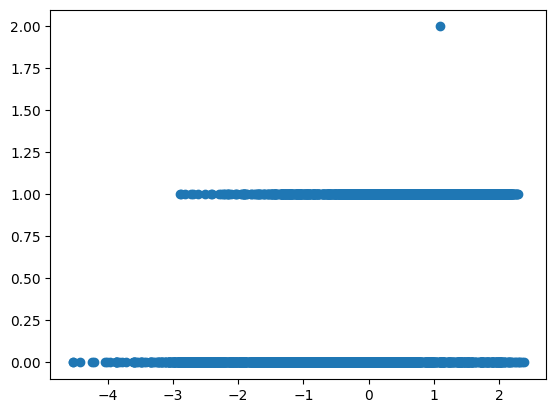

In [755]:
plt.scatter(x_new, manual_labels)
plt.show()

In [725]:
print(len(y_new))
print(np.shape(x_new))

5921
(5921, 1)


PCA

In [893]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

pca = PCA(n_components=7)
scale = StandardScaler()
ax = np.vstack([social_averted_features, mirror_averted_features])
ax_scale = scale.fit_transform(ax)
pca_model = pca.fit(ax_scale, ay)

In [894]:
print(pca_model.explained_variance_ratio_)
print(pca_model.components_)
print(pca_model.singular_values_)
x1_pca = pca_model.fit_transform(social_averted_features)
x2_pca = pca_model.fit_transform(mirror_averted_features)
print(x1_pca.shape)

[0.40091665 0.27913589 0.1373585  0.09811013 0.02875003 0.01881645
 0.01152777]
[[ 0.00401374  0.16726457  0.2840039   0.24788631  0.35123243  0.33831707
   0.16606504  0.20140049  0.35842467  0.36360588  0.36351469  0.36210191]
 [-0.25057055  0.03347621 -0.35065819 -0.35525119 -0.20921003 -0.25789803
  -0.40146297 -0.18312057  0.30795309  0.30937331  0.30994301  0.30875824]
 [-0.58271611  0.61880811  0.03388698 -0.00331073  0.17932519  0.18432349
  -0.32914071  0.13754279 -0.15068106 -0.13834006 -0.1414218  -0.14536849]
 [ 0.35992474  0.37539302 -0.2657231  -0.24293263 -0.22606993 -0.10180051
   0.14408476  0.71909314  0.00914126  0.01732569  0.00689964  0.01231136]
 [ 0.2317297  -0.17552604 -0.17741145 -0.61477993  0.46780305  0.50261474
  -0.15197062 -0.04607473 -0.06006263 -0.03984332 -0.05365388 -0.03619105]
 [ 0.29269961 -0.11545938 -0.4183553   0.5872824   0.10819267  0.1256494
  -0.58017505  0.12641494 -0.01747804 -0.01887889 -0.01790241  0.00382817]
 [-0.06031733 -0.26495675  

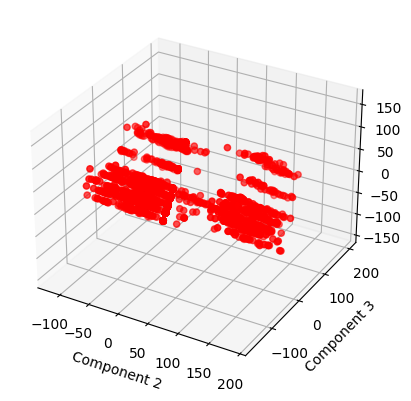

In [895]:
axes = plt.axes(projection ="3d")
axes.scatter3D(x1_pca[:,1],x1_pca[:,2], x1_pca[:,3], color = 'red')
plt.xlabel("Component 2")
plt.ylabel("Component 3")
plt.show()

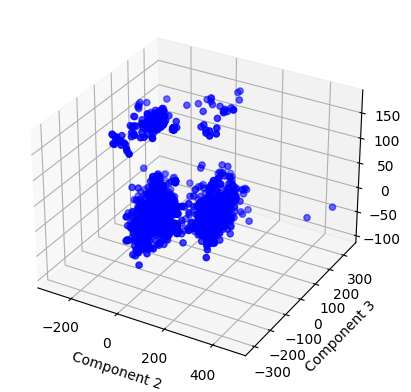

In [896]:
axes = plt.axes(projection ="3d")
axes.scatter3D(x2_pca[:,1],x2_pca[:,2], x2_pca[:,3], color = 'blue')
plt.xlabel("Component 2")
plt.ylabel("Component 3")
plt.show()

In [897]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

lda = LinearDiscriminantAnalysis(n_components=1)
scale = Normalizer()
ax = scale.fit_transform(np.vstack([x1_pca, x2_pca]))
lda_model = lda.fit(ax, ay)

In [898]:
print(lda_model.explained_variance_ratio_)
lda_x = lda_model.fit_transform(ax, ay)
print(lda_x)
lda_y = lda_model.predict(ax)
print(np.mean(lda_y))

[1.]
[[ 0.25877117]
 [-1.1919896 ]
 [-1.27447785]
 ...
 [ 0.75974138]
 [ 2.14554327]
 [ 1.27519204]]
0.7675297675297675


In [899]:
avert_pca_1 = pca_model.fit_transform(averted_features_1)
print(avert_pca_1.shape)

(2419, 7)


In [903]:

y_new_1 = lda_model.predict(pca_model.fit_transform(averted_features_1))
print(np.mean(y_new_1))
if num_videos > 1:
    y_new_2 = model.predict(averted_features_2)
    print(np.mean(y_new_2))
if num_videos > 2:
    y_new_3 = model.predict(averted_features_3)
    print(np.mean(y_new_3))
if num_videos > 3:
    y_new_4 = model.predict(averted_features_4)
    print(np.mean(y_new_4))

0.4915254237288136


Component 1 domain does not seem significant to forming clusters

In [ ]:
vidcap = cv2.VideoCapture(video_path_1) # insert video path here
success,image = vidcap.read()
count = 0
a = -1
i = -1
while success:
    if y_labels_juice_1[count] == 0 and (x_predict_1[count, 0] > 0.75 or x_predict_1[count, 1] > 0.75 or x_predict_1[count, 2] > 0.75 or x_predict_1[count, 3] > 0.75): 
        i += 1
        if y_labels_new_1[i] == 0:
            a += 1
            if i % 10 == 0:
                if y_stereo_averted_4[a] == 0:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/asocial/" + str(session) + "frame%d.jpg" % i, image)
                else:
                    cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/social/" + str(session) + "frame%d.jpg" % i, image)
    success,image = vidcap.read()
    count += 1
a = -1
if num_videos > 1:
    vidcap = cv2.VideoCapture(video_path_2) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_2[count] == 0 and (x_predict_2[count, 0] > 0.75 or x_predict_2[count, 1] > 0.75 or x_predict_2[count, 2] > 0.75 or x_predict_2[count, 3] > 0.75):
            i += 1
            if y_labels_new_2[i] == 0:
                a += 1
                if i % 10 == 0:
                    if y_stereo_averted_2[a] == 0:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/asocial/" + str(session) + "frame%d.jpg" % i, image)
                    else:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/social/" + str(session) + "frame%d.jpg" % i, image)
        success,image = vidcap.read()
        count += 1
a = -1
if num_videos > 2:
    vidcap = cv2.VideoCapture(video_path_3) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_3[count] == 0 and (x_predict_3[count, 0] > 0.75 or x_predict_3[count, 1] > 0.75 or x_predict_3[count, 2] > 0.75 or x_predict_3[count, 3] > 0.75):
            i += 1
            if y_labels_new_3[i] == 0:
                a += 1
                if i % 10 == 0:
                    if y_stereo_averted_3[a] == 0:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/asocial/" + str(session) + "frame%d.jpg" % i, image)
                    else:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/social/" + str(session) + "frame%d.jpg" % i, image)
        success,image = vidcap.read()
        count += 1
a = -1
if num_videos > 3:
    vidcap = cv2.VideoCapture(video_path_4) # insert video path here
    success,image = vidcap.read()
    count = 0
    i = -1
    while success:
        if y_labels_juice_4[count] == 0 and (x_predict_4[count, 0] > 0.75 or x_predict_4[count, 1] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 2] > 0.75 or x_predict_4[count, 3] > 0.75):
            i += 1
            if y_labels_new_4[i] == 0:
                a += 1
                if i % 10 == 0:
                    if y_stereo_averted_4[a] == 0:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/asocial/" + str(session) + "frame%d.jpg" % i, image)
                    else:
                        cv2.imwrite("c:/Users/13108/Desktop/Noah/Side-Juicer-Control/LDA_Labels/social/" + str(session) + "frame%d.jpg" % i, image)
        success,image = vidcap.read()
        count += 1

### Loading/Saving Data and Train/Test Splitting

For concatenating new training data to the current dataset, since we want to compile data from multiple sessions into the dataset.

In [81]:
# run this when we don't have any data in the training set yet
x = x_features_new_1 
y = y_labels_new_1
if num_videos > 1:
    x = np.concatenate((x, x_features_new_2))
    y = np.concatenate((y, y_labels_new_2))
if num_videos > 2:
    x = np.concatenate((x, x_features_new_3))
    y = np.concatenate((y, y_labels_new_3))
if num_videos > 3:
    x = np.concatenate((x, x_features_new_4))
    y = np.concatenate((y, y_labels_new_4))

In [1858]:
#run this when we already have existing training data
x_saved = np.load('feature_data_new.npy')
y_saved = np.load('label_data_new.npy')

x = np.concatenate((x_saved, x_features_new_1))
y = np.concatenate((y_saved, y_labels_new_1))
if num_videos > 1:
    x = np.concatenate((x, x_features_new_2))
    y = np.concatenate((y, y_labels_new_2))
if num_videos > 2:
    x = np.concatenate((x, x_features_new_3))
    y = np.concatenate((y, y_labels_new_3))
if num_videos > 3:
    x = np.concatenate((x, x_features_new_4))
    y = np.concatenate((y, y_labels_new_4))

In [2352]:
# run this when we don't have any data in the training set yet
xj = x_features_j
yj = y_labels_juice

# run this when we already have existing training data
x_savedj = np.load('juice_feature_data.npy')
y_savedj = np.load('juice_label_data.npy')
xj = np.concatenate((x_savedj, x_features_j))
yj = np.concatenate((y_savedj, y_labels_juice))

In [1859]:
# overwrite existing data in the file
np.save('feature_data_new.npy', x)
np.save('label_data_new.npy', y)

In [2354]:
# overwrite existing data in the file
#xj = x_features_j
#yj = y_labels_juice
np.save('juice_feature_data.npy', xj)
np.save('juice_label_data.npy', yj)

In [144]:
# OPTIONAL IF KERNEL SHUT DOWN and need to access the training data
x = np.load('feature_data_new.npy')
y = np.load('label_data_new.npy')

xj = np.load('juice_feature_data.npy')
yj = np.load('juice_label_data.npy')

In [4]:
print(manual_features.shape)
print(manual_labels.shape)

(5921, 12)
(5921, 1)


In [2]:
#run this when we already have existing training data
manual_features = np.load('manual_features_new.npy')
manual_labels = np.load('manual_labels.npy')

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(manual_features, manual_labels, test_size=0.01, random_state=42) # test_size can be changed
num_train_samples, num_features = X_train.shape
num_test_samples, _ = X_test.shape
y_train = np.reshape(y_train, (num_train_samples,))
y_test = np.reshape(y_test, (num_test_samples,))

In [692]:
#print('training set size:', X_train.shape)
#print('test set size:', X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

y_train (1480,)
y_test (4441,)


In [700]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mirror_manual_features, mirror_manual_labels, test_size=0.15, random_state=42) # test_size can be changed
num_train_samples, num_features = X_train.shape
num_test_samples, _ = X_test.shape
y_train = np.reshape(y_train, (num_train_samples,))
y_test = np.reshape(y_test, (num_test_samples,))

likelihoods_averted = []
all_coords_averted = []
for i in range(len(nm1)):
    if y_labels_juice_1[i] == 0:
        likelihoods_clean.append(likelihoods_1[i])
        all_coords_clean.append(all_coords_1[i])
x_features_new_1 = get_sideview_features(likelihoods_clean,all_coords_clean)
nm1 = len(x_features_new_1)
if num_videos > 1:
    likelihoods_clean = []
    all_coords_clean = []
    count = 0
    for i in range(num_examples_2):
        if y_labels_juice_2[i] == 0:
            likelihoods_clean.append(likelihoods_2[i])
            all_coords_clean.append(all_coords_2[i])
            count += 1
    x_features_new_2 = get_sideview_features(likelihoods_clean,all_coords_clean)
    nm2 = len(x_features_new_2)
if num_videos > 2:
    likelihoods_clean = []
    all_coords_clean = []
    for i in range(num_examples_3):
        if y_labels_juice_3[i] == 0:
            likelihoods_clean.append(likelihoods_3[i])
            all_coords_clean.append(all_coords_3[i])
    x_features_new_3 = get_sideview_features(likelihoods_clean,all_coords_clean)
    nm3 = len(x_features_new_3)
if num_videos > 3:
    likelihoods_clean = []
    all_coords_clean = []
    for i in range(num_examples_4):
        if y_labels_juice_4[i] == 0:
            likelihoods_clean.append(likelihoods_4[i])
            all_coords_clean.append(all_coords_4[i])
    x_features_new_4 = get_sideview_features(likelihoods_clean,all_coords_clean)
    nm4 = len(x_features_new_4)
print(len(likelihoods_2))
print(len(x_features_new_2))

### Train Binary Classification Model

In [6]:
from sklearn.linear_model import LogisticRegression # or can use a different model, e.g. SVM or random forest

In [27]:
logreg_clf = LogisticRegression(random_state=42, max_iter=10000).fit(X_train, y_train)

In [46]:
logreg_clf_j = LogisticRegression(random_state=42, max_iter=1500).fit(X_trainj, y_trainj)

In [28]:
# evaluate performance of the classifier 
logreg_test_preds = logreg_clf.predict(X_test)
print('test set accuracy:', np.mean(logreg_test_preds == y_test))

test set accuracy: 0.8155230596175478


In [10]:
# evaluate performance of the classifier 
logreg_manual_preds = logreg_clf.predict(manual_features)
print('test set accuracy:', np.mean(logreg_manual_preds == manual_labels))

test set accuracy: 0.4999454479190784


In [299]:
heuristic_labels = averted_classifier(manual_features, len(manual_features))
print('test set accuracy:', np.mean(heuristic_labels == y_test))

test set accuracy: 0.530933633295838


In [25]:
# evaluate performance of the classifier 
logreg_train_preds = logreg_clf.predict(X_train)
#print(' train set accuracy:', np.mean(list(logreg_test_preds) == list(y_train)))
print(y_train)
print(logreg_train_preds)

[1 0 0 ... 1 1 1]
[1 1 1 ... 1 0 1]


**Poor performance?** (< 90% accuracy)

Possible issues: 

1. If using Method 2 in the Ground Truth Labeling step, the heuristics could be off. Consider using Method 1 instead.
2. This Feature Engineering step is currently adapted to **side view videos from April 26, 2023 onward.** Consider using different features corresponding to any new setups, since transfer learning won't work well.

Test for Linear Separability 

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

svm = SVC(C=1.0, kernel='linear', random_state=0)
svm.fit(manual_features, manual_labels)
 
predicted = svm.predict(manual_features)
 
cm = confusion_matrix(y, predicted)
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('SVM Linear Kernel Confusion Matrix - Setosa')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

c:\Users\13108\.conda\envs\DEEPLABCUT\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Classification 

In [14]:
# trying a different model (CAN SKIP THIS)
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV

svm_params = {'penalty': ['l1', 'l2'], 'C': [1E-7, 1E-6, 1E-6, 1E-4, 1E-3]}
svm_clf = svm.SVC()
search = RandomizedSearchCV(svm_clf, scoring='average_precision', cv=5,
                            n_iter=5, param_distributions=svm_params,
                            refit=True, n_jobs=-1, verbose=2)
search.fit(X_train, y_train)
svm_clf = search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\13108\.conda\envs\DEEPLABCUT\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: Invalid parameter 'penalty' for estimator SVC(). Valid parameters are: ['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'].

In [958]:
svm_test_preds = svm_clf.predict(X_test)
print('test set accuracy:', np.mean(svm_test_preds == y_test))

KeyboardInterrupt: 

XGBoost

In [27]:
import sys
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install hyperopt

     ---------------------------------------- 1.6/1.6 MB 16.7 MB/s eta 0:00:00
     -------------------------------------- 840.9/840.9 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 200.5/200.5 kB ? eta 0:00:00
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492055 sha256=dd070bef725f877a05ff216db4bb7a196d896c3dbfd7a857b4fb1cd0438e70d5
  Stored in directory: c:\users\13108\appdata\local\pip\cache\wheels\a0\0b\ee\e6994fadb42c1354dcccb139b0bf2795271bddfe6253ccdf11
Successfully built future


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [29]:
import xgboost
from xgboost import XGBClassifier

In [30]:
import pandas as pd


# import numpy for Scientific computations
import numpy as np


# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [31]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [34]:
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 250, 1),  # Adjust the range as needed
    'seed': 0
}


In [44]:
def hyperparameter_tuning(space):
    model = xgb.XGBClassifier( max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                         colsample_bytree=int(space['colsample_bytree']),  objective='binary:logistic')
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="error",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [56]:
def hyperparameter_tuning(space):
    model = xgb.XGBClassifier(
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],
         objective='binary:logistic',
         num_class=1
    )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    model.fit(
        X_train, y_train,
        eval_set=evaluation,
        eval_metric="error",
        early_stopping_rounds=10,
        verbose=False
    )

    pred = model.predict(X_test)
    p_shape = pred.shape
    y_shape = y_test.shape
    accuracy = accuracy_score(y_test, pred)  # Removed "> 0.5" threshold
    print("SCORE:", accuracy)
    # change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}


In [48]:
hyperparameter_tuning(space)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Apply'

In [33]:
print(np.size(X_train))
print(np.size(X_train))
print(np.size(X_train))
print(np.size(X_train))

60384
60384
60384
60384


In [58]:
from hyperopt import STATUS_OK, fmin, tpe, Trials

# Import other necessary libraries here

trials = Trials()

best_hyperparams = fmin(fn=hyperparameter_tuning,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

c:\Users\13108\.conda\envs\DEEPLABCUT\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\13108\.conda\envs\DEEPLABCUT\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

job exception: [14:00:41] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\metric\elementwise_metric.cu:346: Check failed: preds.Size() == info.labels.Size() (15096 vs. 5032) : label and prediction size not match, hint: use merror or mlogloss for multi-class classification



  0%|          | 0/100 [00:14<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [28]:
trials = Trials()

best_hyperparams = fmin(fn = hyperparameter_tuning,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: [10:36:59] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\metric\elementwise_metric.cu:346: Check failed: preds.Size() == info.labels.Size() (2667 vs. 889) : label and prediction size not match, hint: use merror or mlogloss for multi-class classification



  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]


XGBoostError: [10:36:59] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\metric\elementwise_metric.cu:346: Check failed: preds.Size() == info.labels.Size() (2667 vs. 889) : label and prediction size not match, hint: use merror or mlogloss for multi-class classification

In [27]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [57]:
xgb_classifier = XGBClassifier(n_estimators=2, max_depth=10, learning_rate=0.1, objective='binary:logistic')
xgb_classifier.fit(X_train, y_train)
xgb_predict = xgb_classifier.predict(X_test)
xgb_opt = xgb_classifier
opt_acc = np.mean(xgb_predict == y_test)
for max_depth in range(0,15):
    for lr in np.arange(0.1,1.0,0.1):
        for gamma in range(1,9):
            for min_child_weight in range(0,10):
                for size in np.arange(0.5,1,0.1):
                    xgb_classifier = XGBClassifier(n_estimators=2, gamma=gamma, min_child_weight=min_child_weight,
                                        max_depth=max_depth, learning_rate=lr, objective='binary:logistic', subsample=size, booster = 'gbtree')
                    xgb_classifier.fit(X_train, y_train)
                    xgb_predict = xgb_classifier.predict(X_test)
                    if np.mean(xgb_predict == y_test) > opt_acc:
                        xgb_opt = xgb_classifier
                        opt_acc = np.mean(xgb_predict == y_test)
         
print('test set accuracy:', opt_acc)

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x0000029242819730>>
Traceback (most recent call last):
  File "c:\Users\13108\.conda\envs\DEEPLABCUT\lib\site-packages\xgboost\core.py", line 588, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


: 

In [64]:
xgb_classifier = XGBClassifier(n_estimators=2, max_depth=10, learning_rate=0.1, objective='binary:logistic')
xgb_classifier.fit(X_train, y_train)
xgb_predict = xgb_classifier.predict(X_test)
xgb_opt = xgb_classifier
opt_acc = np.mean(xgb_predict == y_test)
for min_child_weight in range(0,10):
    xgb_classifier = XGBClassifier(n_estimators=2, gamma=8,  
                                        max_depth=14, learning_rate=0.9, objective='binary:logistic', booster = 'gbtree')
    xgb_classifier.fit(X_train, y_train)
    xgb_predict = xgb_classifier.predict(X_test)
    if np.mean(xgb_predict == y_test) > opt_acc:
        xgb_opt = xgb_classifier
        opt_acc = np.mean(xgb_predict == y_test)
         
print('test set accuracy:', opt_acc)   

test set accuracy: 0.8627671541057368


In [701]:
xgb_classifier = XGBClassifier(n_estimators=2, gamma=8,  
                                        max_depth=14, learning_rate=0.9, objective='binary:logistic', booster = 'gbtree')
xgb_classifier.fit(X_train, y_train)
xgb_predict = xgb_classifier.predict(X_test)
print(np.mean(xgb_predict == y_test))

0.8295454545454546


In [775]:
xgb_opt_2 = xgb_classifier

In [63]:
print(xgb_classifier.get_params)

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=8, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.9, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)>


In [69]:

xgb_predict = xgb_opt.predict(X_train)
print('test set accuracy:', np.mean(xgb_predict == y_train))

test set accuracy: 0.9080361713018257


In [71]:
np.shape(X_train)

(5861, 12)

In [ ]:
RANDOM FOREST